## Analise de Distribuição de Massa em galáxias com componente barra

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Tabela completa -- Para comparações
SaloButa_S4G = pd.read_csv('Salo15(4629)+IRSA_S4G(2352)+Bouquin18(1931)+Buta15.csv')

#Nossa amostra final
amostra_430 = pd.read_csv('amostra_430.csv')

#Definindo colunas de interesse -- Apenas necessário na tabela completa
Colunas_interesse = SaloButa_S4G[['Name_1','Mod','Nc','Q','C','Fn','f1','mag1_1','f2','mu02','f3',
                                  'mag3','f4','mu04','f5','mag5','mag1_2','mag2',
                                  'mstar','dmean','type','t_1','incl','Dist','__T_','__F_']] 

#Tirando as linhas duplicadas -- uma linha para cada componente do modelo
s4g_comps = Colunas_interesse.drop(index=0) #Removendo a primeira linha, que é apenas um indice que eu uso para me
#orientar com as colunas na tabela completa, pois são muitas colunas
s4g_2277 = s4g_comps.drop_duplicates(subset='Name_1')

/tmp/ipykernel_94180/14545723.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  SaloButa_S4G = pd.read_csv('Salo15(4629)+IRSA_S4G(2352)+Bouquin18(1931)+Buta15.csv')


In [3]:
print(amostra_430['Name_1'][150],len(s4g_comps['Name_1']), s4g_comps['Name_1'][1])

NGC3353 4629 ESO011-005


In [68]:
#Procura galáxia da nossa amostra na tabela completa para pegar as linhas das outras componentes 
#obs: criando a nossa amostra, filtrei apenas pelas linhas com barra, mas para essa etapa eu preciso das linhas das outras
#componentes.
for j in range(len(s4g_comps['Name_1'])): #Usa o nome da galáxia como referência
    if amostra_430['Name_1'][152] == Colunas_interesse['Name_1'][j]:
        print(Colunas_interesse.iloc[[j]]['Name_1'])

1696    NGC3380
Name: Name_1, dtype: object
1697    NGC3380
Name: Name_1, dtype: object
1698    NGC3380
Name: Name_1, dtype: object
1699    NGC3380
Name: Name_1, dtype: object


In [69]:
amostra_430[['Mod']].value_counts() #Os modelos presentes na nossa amostra 

Mod     
_dbar       156
_bdbarf      59
_dbarn       55
_bdbar       51
_dbarf       43
_dbarfn      36
_bdbarfn     15
_ndbar        8
_bdbarn       3
_dbarnf       2
_dnbar        1
_nbdbar       1
dtype: int64

In [9]:
def mag_to_flux(mag):
	''' 
    Descrição:
    
    Essa função irá fazer a conversão de magnitude para fluxo. magAB para fluxo em Jansky [Jy].
    
    Entrada: mag_to_flux(mag)
    
	Parametros:
	mag (float): magnitude do objeto [mag AB]
    
    Retorna: Fluxo [Jy]
	'''

	flux = 10**((mag)*(-2)/5)*3630.780547701
	
	return flux

def flux_to_mass(flux3,flux4,dist): 
	'''
    Descrição:
    
	Esta função utiliza a equação desenvolvida em Eskew et al. (2012) para converter os fluxos [Jy] em duas bandas do infravermelho (3.6 e 4.5um)
    em massa estelar. Também é necessário conhecer o valor da distância [Mpc] do objeto.
    A função devolve o valor da massa em log10(M*).
    
    Entrada: flux_to_mass(flux3,flux4,dist)
    
    Parametros:
    flux3 (float): Valor do fluxo em 3.6um [Jy].
    flux4 (float): Valor do fluxo em 4.5um [Jy].
    dist (float): Valor da distância do objeto [Mpc].
    
    Retorna: log10(Massa)
	'''
	mass = 10**(5.65)*(flux3)**(2.85)*(flux4)**(-1.85)*((dist)/(0.05))**2 
	
	return np.log10(mass)  #Devolve a massa em log10

def mass_rel(cflux3,cflux4,mflux3,mflux4,dist):
    '''
    Descrição:
    
    Esta função verifica a massa relativa de uma componente considerando a massa calculada da componente e a massa calculada total do modelo.
    Para isso é necessário informar os valores de fluxos nas bandas 3.6 e 4.5um [Jy]da componente e do modelo, além do valor da distância [Mpc]
    do objeto.
    
    Entrada: mass_rel(mass_rel(cflux3,cflux4,mflux3,mflux4,dist)
    
    Parametros:
    cflux3 (float): Valor do fluxo em 3.6um [Jy] da componente.
    
    cflux4 (float): Valor do fluxo em 4.5um [Jy] da componente.
    mflux3 (float): Valor do fluxo em 3.6um [Jy] do modelo.
    mflux4 (float): Valor do fluxo em 4.5um [Jy] do modelo.
    dist (float): Valor da distância do objeto [Mpc].
    
    Retorna: Massa relativa [%] (massa_componente*100)/(massa_modelo)
    '''
    
    c_mass = 10**(5.65)*(cflux3)**(2.85)*(cflux4)**(-1.85)*((dist)/(0.05))**2 #massa da componente
    M_mass = 10**(5.65)*(mflux3)**(2.85)*(mflux4)**(-1.85)*((dist)/(0.05))**2 #massa do modelo
    Rel_mass = (c_mass*100)/M_mass #massa relativa da componente
    
    return Rel_mass

In [10]:
def gals_dbar(tabela, plot=False, saveplot=False, List_MBAR =False, List_flux3=False, List_flux4=False):

    from tqdm import tqdm
    obj_dbar = []
    mod_dbar = []
    mstar_dbar = []
    flux_D_dbar = []
    flux_BAR_dbar = []
    flux_mod3_dbar = []
    flux_mod4_dbar = []
    flux_D_dbar4 = []
    flux_BAR_dbar4 = []
    MBAR_dbar = []
    MD_dbar = []
    MOBS_dbar = []
    MMOD_dbar = []
    MBAR_Rel_dbar = []
    MD_Rel_dbar = []
    componentes_dfe =[]
    flux_3obs =[]
    flux_4obs =[]

    for i in tqdm(range((len(tabela)))):

        if str(tabela.Mod[i]) == '_dbarf' or str(tabela.Mod[i]) == '_dbar':

            componentes_df = pd.DataFrame()
            componentes_dfe =[]

            for j in range(len(s4g_comps['Name_1'])): #Usa o nome da galáxia como referência
                if tabela['Name_1'][i] == Colunas_interesse['Name_1'][j]:

                    componentes_dfe.append(Colunas_interesse.iloc[[j]])

            componentes_df = pd.concat(componentes_dfe)

            mask_D = componentes_df.C == 'D'
            mask_BAR = componentes_df.C == 'BAR'
            obj_dbar.append(componentes_df.Name_1[mask_D])
            mod_dbar.append(componentes_df.Mod[mask_D])
            mstar_dbar.append(componentes_df.mstar[mask_D])

            #Calculo do fluxo da componente disco --------------------------------------------------
            flux_disk =  mag_to_flux(float(componentes_df[mask_D].mag3)) #fluxo da comp disco em 3.6um
            flux_D_dbar.append(flux_disk)

            #MAG 3.6 E 4.5 (Observado, Tabela S4G IRSA) PARA FLUXO ---------------------------------
            flux_3 = mag_to_flux(float(componentes_df[mask_D].mag1_2)) #fluxo obs da gal em 3.6um
            flux_4 = mag_to_flux(float(componentes_df[mask_D].mag2)) #fluxo obs da gal em 4.5um
            
            flux_3obs.append(flux_3)
            flux_4obs.append(flux_4)

            #O FLUXO DO MODELO =  FLUXO DO DISCO / (%disco/modelo) ----------------------------------
            fluxmod3 = flux_disk / float(componentes_df[mask_D].f3)    # fluxo do modelo em 3.6 
            flux_mod3_dbar.append(fluxmod3)

            #FLUXO DO MODELO EM 4.5 = ((FLUXO OBSERVADO EM 4.5) * (FLUXO DO MODELO em 3.6)) / (FLUXO OBSERVADO EM 3.6)
            fluxmod4 = (flux_4*fluxmod3)/flux_3    ##### fluxo do modelo em 4.5
            flux_mod4_dbar.append(fluxmod4)

            #FLUXO DO DISCO EM 4.5 =  (%DISCO/MODELO ) * (FLUXO DO MODELO EM 4.5) --------------------
            flux_disk4 =  float(componentes_df[mask_D].f3)*fluxmod4 #fluxo estamado para a comp disco em 4.5um

            flux_D_dbar4.append(flux_disk4)

            #Fluxo da componente BARRA ----------------------------------------------------------------
            flux_bar3 = fluxmod3 - flux_disk #fluxo da componente barra em 3.6um
            flux_bar4 = float(componentes_df[mask_BAR].f4)*fluxmod4 #fluxo estimado para a componente barra em 4.5um

            flux_BAR_dbar.append(flux_bar3)
            flux_BAR_dbar4.append(flux_bar4)

            if np.isnan(float(componentes_df['Dist'][mask_BAR])):
                dist = float(componentes_df['dmean'][mask_BAR])

                Mdisk = flux_to_mass(flux_disk,flux_disk4,dist) #Massa contida na componente disco -- log10(Msun)
                Mbar = flux_to_mass(flux_bar3,flux_bar4,dist) #Massa contida na componente barra -- log10(Msun)
                Mobs = flux_to_mass(flux_3,flux_4,dist) #Massa observada total da galáxia -- log10(Msun)
                Mmod = flux_to_mass(fluxmod3,fluxmod4,dist) #Massa total do modelo -- log10(Msun)

                MBAR_dbar.append(Mbar)
                MD_dbar.append(Mdisk)
                MOBS_dbar.append(Mobs)
                MMOD_dbar.append(Mmod)
                MBAR_Rel_dbar.append(mass_rel(cflux3=flux_bar3, cflux4=flux_bar4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MD_Rel_dbar.append(mass_rel(cflux3=flux_disk, cflux4=flux_disk4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
            else:
                dist = float(componentes_df['Dist'][mask_BAR])

                Mdisk = flux_to_mass(flux_disk,flux_disk4,dist) #Massa contida na componente disco -- log10(Msun)
                Mbar = flux_to_mass(flux_bar3,flux_bar4,dist) #Massa contida na componente barra -- log10(Msun)
                Mobs = flux_to_mass(flux_3,flux_4,dist) #Massa observada total da galáxia -- log10(Msun)
                Mmod = flux_to_mass(fluxmod3,fluxmod4,dist) #Massa total do modelo -- log10(Msun)

                MBAR_dbar.append(Mbar)
                MD_dbar.append(Mdisk)
                MOBS_dbar.append(Mobs)
                MMOD_dbar.append(Mmod)
                MBAR_Rel_dbar.append(mass_rel(cflux3=flux_bar3, cflux4=flux_bar4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MD_Rel_dbar.append(mass_rel(cflux3=flux_disk, cflux4=flux_disk4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))


    if plot:
        fig = plt.figure(figsize=(17,5))
        ax1 = fig.add_subplot(1,2,1)
        ax2 = fig.add_subplot(1,2,2)
        
        ax1.hist(MBAR_Rel_dbar,bins=15, align='mid',color='m',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax1.set_title('Massa Relativa da componente Barra em %i galáxias' %len(MBAR_Rel_dbar),fontsize=14)
        ax1.set_ylabel('N',fontsize=14)
        ax1.set_xlabel('% (Massa_Barra * 100)/Massa_Modelo' ,fontsize=14)
        ax1.axvline(np.mean(MBAR_Rel_dbar),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MBAR_Rel_dbar)))
        ax1.axvline(np.median(MBAR_Rel_dbar),alpha = 0.4, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MBAR_Rel_dbar)))
        ax1.axvline(np.mean(MBAR_Rel_dbar) + np.std(MBAR_Rel_dbar),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MBAR_Rel_dbar)))
        ax1.axvline(np.mean(MBAR_Rel_dbar) - np.std(MBAR_Rel_dbar),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax1.axvline(np.mean(MBAR_Rel_dbar) + 2*np.std(MBAR_Rel_dbar),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MBAR_Rel_dbar)))
        ax1.axvline(np.mean(MBAR_Rel_dbar) - 2*np.std(MBAR_Rel_dbar),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax1.axvline(np.mean(MBAR_Rel_dbar) + 3*np.std(MBAR_Rel_dbar),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MBAR_Rel_dbar)))
        ax1.axvline(np.mean(MBAR_Rel_dbar) - 3*np.std(MBAR_Rel_dbar),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax1.legend(loc='best',fontsize=14)
        ax1.set_xlim(np.min(MBAR_Rel_dbar)- len(MBAR_Rel_dbar)//(len(MBAR_Rel_dbar)*0.7),np.max(MBAR_Rel_dbar)+len(MBAR_Rel_dbar)//(len(MBAR_Rel_dbar)*0.7))

        ax2.hist(MD_Rel_dbar,bins=15,align='mid',color='c',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax2.set_title('Massa Relativa da componente Disco em %i galáxias' %len(MD_Rel_dbar),fontsize=14)
        ax2.set_ylabel('N',fontsize=14)
        ax2.set_xlabel('% (Massa_Disco * 100)/Massa_Modelo',fontsize=14)
        ax2.axvline(np.mean(MD_Rel_dbar),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MD_Rel_dbar)))
        ax2.axvline(np.median(MD_Rel_dbar),alpha = 0.5, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MD_Rel_dbar)))
        ax2.axvline(np.mean(MD_Rel_dbar) + np.std(MD_Rel_dbar),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MD_Rel_dbar)))
        ax2.axvline(np.mean(MD_Rel_dbar) - np.std(MD_Rel_dbar),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax2.axvline(np.mean(MD_Rel_dbar) + 2*np.std(MD_Rel_dbar),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MD_Rel_dbar)))
        ax2.axvline(np.mean(MD_Rel_dbar) - 2*np.std(MD_Rel_dbar),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax2.axvline(np.mean(MD_Rel_dbar) + 3*np.std(MD_Rel_dbar),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MD_Rel_dbar)))
        ax2.axvline(np.mean(MD_Rel_dbar) - 3*np.std(MD_Rel_dbar),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax2.legend(loc='best',fontsize=14)
        ax2.set_xlim(np.min(MD_Rel_dbar)- len(MD_Rel_dbar)//(len(MD_Rel_dbar)*0.7),np.max(MD_Rel_dbar)+len(MD_Rel_dbar)//(len(MD_Rel_dbar)*0.7))

        if saveplot: #se True, salva a imagem
            
            image_name = 'Distribuicao_de_massa_em_%i_galaxias_dbar.png' %len(MOBS_dbar)
            plt.savefig(image_name, format='png')
            plt.show()
        
        fig = plt.figure(figsize=(20,6))
        ax3 = fig.add_subplot(1,2,1)
        ax4 = fig.add_subplot(1,2,2)
        
        iden = np.linspace(np.min(MOBS_dbar),np.max(MMOD_dbar),num=30) # x=y
        ax3.plot(MOBS_dbar,MMOD_dbar, 'k.',alpha=0.5)
        ax3.plot(iden,iden,'r--',alpha=0.8)
        ax3.set_title('Comparação massa do modelo com massa da galáxia -- %i galáxias' %len(MOBS_dbar),fontsize=14)
        ax3.set_ylabel('log10(Massa do modelo)',fontsize=14)
        ax3.set_xlabel('log10(Massa galáxia (equação))',fontsize=14)

        ax4.plot(MOBS_dbar,mstar_dbar, 'k.',alpha=0.5)
        ax4.plot(iden,iden,'r--',alpha=0.8)
        ax4.set_title('Comparação massa calculada com massa tabelada (S4G, IRSA) -- %i galáxias' %len(MOBS_dbar),fontsize=14)
        ax4.set_ylabel('log10(Massa tabelada) -- Mstar, IRSA',fontsize=14)
        ax4.set_xlabel('log10(Massa calculada) -- equação',fontsize=14)


        ax1.tick_params(labelsize=14)
        ax2.tick_params(labelsize=14)
        ax3.tick_params(labelsize=14)
        ax4.tick_params(labelsize=14)        
        
        if saveplot: #se True, salva a imagem
            
            image_name = 'Distribuicao_de_massa_em_%i_galaxias_dbar_2.png' %len(MOBS_dbar)
            plt.savefig(image_name, format='png')
            plt.show()
            
    if List_MBAR:
        return MBAR_Rel_dbar
    if List_flux3:
        return flux_mod3_dbar, flux_3obs
    if List_flux4:
        return flux_mod4_dbar, flux_4obs

In [11]:
def gals_dbarn(tabela, plot=False, saveplot=False, List_MBAR=False):
    '''
    Descrição:
    Galáxias com modelo disco + barra + nucleo.
    Gera histogramas de massa relativa das componentes 
    '''
    
    from tqdm import tqdm
    obj_dbarn = []
    mod_dbarn = []
    mstar_dbarn = []
    flux_D_dbarn = []
    flux_BAR_dbarn = []
    flux_mod3_dbarn = []
    flux_mod4_dbarn = []
    flux_D_dbarn4 = []
    flux_BAR_dbarn4 = []
    flux_N_dbarn3 = []
    flux_N_dbarn4 = []
    MBAR_dbarn = []
    MD_dbarn = []
    MN_dbarn = []
    MOBS_dbarn = []
    MMOD_dbarn = []
    MBAR_Rel_dbarn = []
    MD_Rel_dbarn = []
    MN_Rel_dbarn = []
    componentes_dfe =[]

    for i in tqdm(range((len(tabela)))):

        if str(tabela.Mod[i]) == '_ndbar' or str(tabela.Mod[i]) == '_dbarn' or str(
            tabela.Mod[i]) == '_dbarfn' or str(tabela.Mod[i]) == '_dbarnf' or str(tabela.Mod[i]) == '_dnbar':

            componentes_df = pd.DataFrame()
            componentes_dfe =[]

            for j in range(len(s4g_comps['Name_1'])): #Usa o nome da galáxia como referência
                if tabela['Name_1'][i] == Colunas_interesse['Name_1'][j]:

                    componentes_dfe.append(Colunas_interesse.iloc[[j]])

            componentes_df = pd.concat(componentes_dfe)

            mask_D = componentes_df.C == 'D' #mascara disco
            mask_BAR = componentes_df.C == 'BAR' #mascara barra
            mask_N = componentes_df.C == 'N' #mascara #nucleo
            
            obj_dbarn.append(componentes_df.Name_1[mask_D]) #lista nomes
            mod_dbarn.append(componentes_df.Mod[mask_D]) #lista modelos
            mstar_dbarn.append(componentes_df.mstar[mask_D]) #lista massas IRSA

            #Calculo do fluxo da componente disco --------------------------------------------------
            flux_disk =  mag_to_flux(float(componentes_df[mask_D].mag3)) #fluxo da comp disco em 3.6um
            flux_D_dbarn.append(flux_disk)

            #MAG 3.6 E 4.5 (Observado, Tabela S4G IRSA) PARA FLUXO ---------------------------------
            flux_3 = mag_to_flux(float(componentes_df[mask_D].mag1_2)) #fluxo obs da gal em 3.6um
            flux_4 = mag_to_flux(float(componentes_df[mask_D].mag2)) #fluxo obs da gal em 4.5um

            #O FLUXO DO MODELO =  FLUXO DO DISCO / (%disco/modelo) ----------------------------------
            fluxmod3 = flux_disk / float(componentes_df[mask_D].f3)    # fluxo do modelo em 3.6 
            flux_mod3_dbarn.append(fluxmod3)

            #FLUXO DO MODELO EM 4.5 = (FLUXO OBSERVADO EM 4.5) * (FLUXO DO MODELO em 3.6) / (FLUXO OBSERVADO EM 3.6)
            fluxmod4 = (flux_4*fluxmod3)/flux_3    ##### fluxo do modelo em 4.5
            flux_mod4_dbarn.append(fluxmod4)

            #FLUXO DO DISCO EM 4.5 =  (%DISCO/MODELO ) * (FLUXO DO MODELO EM 4.5) --------------------
            flux_disk4 =  float(componentes_df[mask_D].f3)*fluxmod4 #fluxo estamado para a comp disco em 4.5um

            flux_D_dbarn4.append(flux_disk4)
            
            #Fluxo da componente nucleo em 3.6um
            flux_n3 = mag_to_flux(float(componentes_df[mask_N].mag5))
            flux_N_dbarn3.append(flux_n3)
            
            #Fluxo da componente nucleo em 4.5um                      
            flux_n4 = float(componentes_df[mask_N].f5)*fluxmod4
            flux_N_dbarn4.append(flux_n4)

            #Fluxo da componente BARRA ----------------------------------------------------------------
            flux_bar3 = fluxmod3 - flux_disk - flux_n3 #fluxo da componente barra em 3.6um
            flux_bar4 = float(componentes_df[mask_BAR].f4)*fluxmod4 #fluxo estimado para a componente barra em 4.5um

            flux_BAR_dbarn.append(flux_bar3)
            flux_BAR_dbarn4.append(flux_bar4)

            if np.isnan(float(componentes_df['Dist'][mask_BAR])):
                dist = float(componentes_df['dmean'][mask_BAR])

                Mdisk = flux_to_mass(flux_disk,flux_disk4,dist) #Massa contida na componente disco -- log10(Msun)
                Mbar = flux_to_mass(flux_bar3,flux_bar4,dist) #Massa contida na componente barra -- log10(Msun)
                Mobs = flux_to_mass(flux_3,flux_4,dist) #Massa observada total da galáxia -- log10(Msun)
                Mmod = flux_to_mass(fluxmod3,fluxmod4,dist) #Massa total do modelo -- log10(Msun)
                Mn = flux_to_mass(flux_n3,flux_n4,dist) #Massa contida na componente nucleo -- log10(Msun)

                MBAR_dbarn.append(Mbar)
                MD_dbarn.append(Mdisk)
                MOBS_dbarn.append(Mobs)
                MMOD_dbarn.append(Mmod)
                MN_dbarn.append(Mn)
                MBAR_Rel_dbarn.append(mass_rel(cflux3=flux_bar3, cflux4=flux_bar4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MD_Rel_dbarn.append(mass_rel(cflux3=flux_disk, cflux4=flux_disk4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MN_Rel_dbarn.append(mass_rel(cflux3=flux_n3, cflux4=flux_n4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
            else:
                dist = float(componentes_df['Dist'][mask_BAR])

                Mdisk = flux_to_mass(flux_disk,flux_disk4,dist) #Massa contida na componente disco -- log10(Msun)
                Mbar = flux_to_mass(flux_bar3,flux_bar4,dist) #Massa contida na componente barra -- log10(Msun)
                Mobs = flux_to_mass(flux_3,flux_4,dist) #Massa observada total da galáxia -- log10(Msun)
                Mmod = flux_to_mass(fluxmod3,fluxmod4,dist) #Massa total do modelo -- log10(Msun)
                Mn = flux_to_mass(flux_n3,flux_n4,dist) #Massa contida na componente nucleo -- log10(Msun)

                MBAR_dbarn.append(Mbar)
                MD_dbarn.append(Mdisk)
                MOBS_dbarn.append(Mobs)
                MMOD_dbarn.append(Mmod)
                MN_dbarn.append(Mn)
                MBAR_Rel_dbarn.append(mass_rel(cflux3=flux_bar3, cflux4=flux_bar4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MD_Rel_dbarn.append(mass_rel(cflux3=flux_disk, cflux4=flux_disk4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MN_Rel_dbarn.append(mass_rel(cflux3=flux_n3, cflux4=flux_n4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))


    if plot:
        fig = plt.figure(figsize=(21,6))
        ax1 = fig.add_subplot(1,3,1)
        ax2 = fig.add_subplot(1,3,2)
        ax5 = fig.add_subplot(1,3,3)

        ax1.hist(MBAR_Rel_dbarn,bins=15, align='mid',color='m',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax1.set_title('Massa Relativa da componente Barra em %i galáxias' %len(MBAR_Rel_dbarn),fontsize=13)
        ax1.set_ylabel('N',fontsize=14)
        ax1.set_xlabel('% (Massa_Barra * 100)/Massa_Modelo' ,fontsize=13)
        ax1.axvline(np.mean(MBAR_Rel_dbarn),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MBAR_Rel_dbarn)))
        ax1.axvline(np.median(MBAR_Rel_dbarn),alpha = 0.4, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MBAR_Rel_dbarn)))
        ax1.axvline(np.mean(MBAR_Rel_dbarn) + np.std(MBAR_Rel_dbarn),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MBAR_Rel_dbarn)))
        ax1.axvline(np.mean(MBAR_Rel_dbarn) - np.std(MBAR_Rel_dbarn),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax1.axvline(np.mean(MBAR_Rel_dbarn) + 2*np.std(MBAR_Rel_dbarn),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MBAR_Rel_dbarn)))
        ax1.axvline(np.mean(MBAR_Rel_dbarn) - 2*np.std(MBAR_Rel_dbarn),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax1.axvline(np.mean(MBAR_Rel_dbarn) + 3*np.std(MBAR_Rel_dbarn),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MBAR_Rel_dbarn)))
        ax1.axvline(np.mean(MBAR_Rel_dbarn) - 3*np.std(MBAR_Rel_dbarn),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax1.legend(loc='best',fontsize=13)
        ax1.set_xlim(np.min(MBAR_Rel_dbarn)- len(MBAR_Rel_dbarn)//(len(MBAR_Rel_dbarn)*0.7),np.max(MBAR_Rel_dbarn)+len(MBAR_Rel_dbarn)//(len(MBAR_Rel_dbarn)*0.7))


        ax2.hist(MD_Rel_dbarn,bins=15,align='mid',color='c',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax2.set_title('Massa Relativa da componente Disco em %i galáxias' %len(MD_Rel_dbarn),fontsize=13)
        ax2.set_ylabel('N',fontsize=14)
        ax2.set_xlabel('% (Massa_Disco * 100)/Massa_Modelo',fontsize=13)
        ax2.axvline(np.mean(MD_Rel_dbarn),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MD_Rel_dbarn)))
        ax2.axvline(np.median(MD_Rel_dbarn),alpha = 0.5, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MD_Rel_dbarn)))
        ax2.axvline(np.mean(MD_Rel_dbarn) + np.std(MD_Rel_dbarn),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MD_Rel_dbarn)))
        ax2.axvline(np.mean(MD_Rel_dbarn) - np.std(MD_Rel_dbarn),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax2.axvline(np.mean(MD_Rel_dbarn) + 2*np.std(MD_Rel_dbarn),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MD_Rel_dbarn)))
        ax2.axvline(np.mean(MD_Rel_dbarn) - 2*np.std(MD_Rel_dbarn),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax2.axvline(np.mean(MD_Rel_dbarn) + 3*np.std(MD_Rel_dbarn),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MD_Rel_dbarn)))
        ax2.axvline(np.mean(MD_Rel_dbarn) - 3*np.std(MD_Rel_dbarn),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax2.legend(loc='best',fontsize=13)
        ax2.set_xlim(np.min(MD_Rel_dbarn)- len(MD_Rel_dbarn)//(len(MD_Rel_dbarn)*0.7),np.max(MD_Rel_dbarn)+len(MD_Rel_dbarn)//(len(MD_Rel_dbarn)*0.7))

        ax5.hist(MN_Rel_dbarn,bins=15,align='mid',color='salmon',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax5.set_title('Massa Relativa da componente Núcleo em %i galáxias' %len(MN_Rel_dbarn),fontsize=13)
        ax5.set_ylabel('N',fontsize=14)
        ax5.set_xlabel('% (Massa_Núcleo * 100)/Massa_Modelo',fontsize=13)
        ax5.axvline(np.mean(MN_Rel_dbarn),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MN_Rel_dbarn)))
        ax5.axvline(np.median(MN_Rel_dbarn),alpha = 0.5, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MN_Rel_dbarn)))
        ax5.axvline(np.mean(MN_Rel_dbarn) + np.std(MN_Rel_dbarn),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MN_Rel_dbarn)))
        ax5.axvline(np.mean(MN_Rel_dbarn) - np.std(MN_Rel_dbarn),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax5.axvline(np.mean(MN_Rel_dbarn) + 2*np.std(MN_Rel_dbarn),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MN_Rel_dbarn)))
        ax5.axvline(np.mean(MN_Rel_dbarn) - 2*np.std(MN_Rel_dbarn),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax5.axvline(np.mean(MN_Rel_dbarn) + 3*np.std(MN_Rel_dbarn),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MN_Rel_dbarn)))
        ax5.axvline(np.mean(MN_Rel_dbarn) - 3*np.std(MN_Rel_dbarn),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax5.legend(loc='best',fontsize=13)
        ax5.set_xlim(np.min(MN_Rel_dbarn)- len(MN_Rel_dbarn)//(len(MN_Rel_dbarn)*0.7),np.max(MN_Rel_dbarn)+len(MN_Rel_dbarn)//(len(MN_Rel_dbarn)*0.7))
        
        if saveplot: #se True, salva a imagem
            
            image_name = 'Distribuicao_de_massa_em_%i_galaxias_dbarn.png' %len(MOBS_dbarn)
            plt.savefig(image_name, format='png')
            plt.show()
            
        fig = plt.figure(figsize=(20,6))
        ax3 = fig.add_subplot(1,2,1)
        ax4 = fig.add_subplot(1,2,2)
            
        iden = np.linspace(np.min(MOBS_dbarn),np.max(MMOD_dbarn),num=30) # x=y
        ax3.plot(MOBS_dbarn,MMOD_dbarn, 'k.',alpha=0.5)
        ax3.plot(iden,iden,'r--',alpha=0.8)
        ax3.set_title('Comparação massa do modelo com massa da galáxia -- %i galáxias' %len(MOBS_dbarn),fontsize=14)
        ax3.set_ylabel('log10(Massa do modelo)',fontsize=14)
        ax3.set_xlabel('log10(Massa galáxia (equação))',fontsize=14)

        ax4.plot(MOBS_dbarn,mstar_dbarn, 'k.',alpha=0.5)
        ax4.plot(iden,iden,'r--',alpha=0.8)
        ax4.set_title('Comparação massa calculada com massa tabelada (S4G, IRSA) -- %i galáxias' %len(MOBS_dbarn),fontsize=14)
        ax4.set_ylabel('log10(Massa tabelada) -- Mstar, IRSA',fontsize=14)
        ax4.set_xlabel('log10(Massa calculada) -- equação',fontsize=14)

        ax1.tick_params(labelsize=14)
        ax2.tick_params(labelsize=14)
        ax3.tick_params(labelsize=14)
        ax4.tick_params(labelsize=14)
        
        if saveplot: #se True, salva a imagem
            
            image_name = 'Distribuicao_de_massa_em_%i_galaxias_dbarn_2.png' %len(MOBS_dbarn)
            plt.savefig(image_name, format='png')
            plt.show()
            
    if List_MBAR:
        return MBAR_Rel_dbarn

In [12]:
def gals_bdbar(tabela, plot=False, saveplot=False, List_MBAR=False):

    from tqdm import tqdm
    obj_dbarb = []
    mod_dbarb = []
    mstar_dbarb = []
    flux_D_dbarb = []
    flux_BAR_dbarb = []
    flux_mod3_dbarb = []
    flux_mod4_dbarb = []
    flux_D_dbarb4 = []
    flux_BAR_dbarb4 = []
    flux_B_dbarb3 =[]
    flux_B_dbarb4 =[]
    MBAR_dbarb = []
    MD_dbarb = []
    MOBS_dbarb = []
    MMOD_dbarb = []
    MB_dbarb = []
    MBAR_Rel_dbarb = []
    MD_Rel_dbarb = []
    MB_Rel_dbarb = []
    componentes_dfe =[]

    for i in tqdm(range((len(tabela)))):

        if str(tabela.Mod[i]) == '_bdbar' or str(tabela.Mod[i]) == '_bdbarf':

            componentes_df = pd.DataFrame()
            componentes_dfe =[]

            for j in range(len(s4g_comps['Name_1'])): #Usa o nome da galáxia como referência
                if tabela['Name_1'][i] == Colunas_interesse['Name_1'][j]:

                    componentes_dfe.append(Colunas_interesse.iloc[[j]])

            componentes_df = pd.concat(componentes_dfe)

            mask_D = componentes_df.C == 'D' #mascara disco
            mask_BAR = componentes_df.C == 'BAR' #mascara barra
            mask_B = componentes_df.C == 'B' #mascara bojo
            
            obj_dbarb.append(componentes_df.Name_1[mask_D]) #lista nomes
            mod_dbarb.append(componentes_df.Mod[mask_D]) #lista modelos
            mstar_dbarb.append(componentes_df.mstar[mask_D]) #lista massas IRSA

            #Calculo do fluxo da componente disco --------------------------------------------------
            flux_disk =  mag_to_flux(float(componentes_df[mask_D].mag3)) #fluxo da comp disco em 3.6um
            flux_D_dbarb.append(flux_disk)

            #MAG 3.6 E 4.5 (Observado, Tabela S4G IRSA) PARA FLUXO ---------------------------------
            flux_3 = mag_to_flux(float(componentes_df[mask_D].mag1_2)) #fluxo obs da gal em 3.6um
            flux_4 = mag_to_flux(float(componentes_df[mask_D].mag2)) #fluxo obs da gal em 4.5um

            #O FLUXO DO MODELO =  FLUXO DO DISCO / (%disco/modelo) ----------------------------------
            fluxmod3 = flux_disk / float(componentes_df[mask_D].f3)    # fluxo do modelo em 3.6 
            flux_mod3_dbarb.append(fluxmod3)

            #FLUXO DO MODELO EM 4.5 = (FLUXO OBSERVADO EM 4.5) * (FLUXO DO MODELO em 3.6) / (FLUXO OBSERVADO EM 3.6)
            fluxmod4 = (flux_4*fluxmod3)/flux_3    ##### fluxo do modelo em 4.5
            flux_mod4_dbarb.append(fluxmod4)

            #FLUXO DO DISCO EM 4.5 =  (%DISCO/MODELO ) * (FLUXO DO MODELO EM 4.5) --------------------
            flux_disk4 =  float(componentes_df[mask_D].f3)*fluxmod4 #fluxo estamado para a comp disco em 4.5um

            flux_D_dbarb4.append(flux_disk4)
            
            #Fluxo da componente bojo em 3.6um
            flux_b3 = mag_to_flux(float(componentes_df[mask_B].mag1_1))
            flux_B_dbarb3.append(flux_b3)
            
            #Fluxo da componente bojo em 4.5um                      
            flux_b4 = float(componentes_df[mask_B].f1)*fluxmod4
            flux_B_dbarb4.append(flux_b4)

            #Fluxo da componente BARRA ----------------------------------------------------------------
            flux_bar3 = fluxmod3 - flux_disk - flux_b3 #fluxo da componente barra em 3.6um
            flux_bar4 = float(componentes_df[mask_BAR].f4)*fluxmod4 #fluxo estimado para a componente barra em 4.5um

            flux_BAR_dbarb.append(flux_bar3)
            flux_BAR_dbarb4.append(flux_bar4)

            if np.isnan(float(componentes_df['Dist'][mask_BAR])):
                dist = float(componentes_df['dmean'][mask_BAR])

                Mdisk = flux_to_mass(flux_disk,flux_disk4,dist) #Massa contida na componente disco -- log10(Msun)
                Mbar = flux_to_mass(flux_bar3,flux_bar4,dist) #Massa contida na componente barra -- log10(Msun)
                Mobs = flux_to_mass(flux_3,flux_4,dist) #Massa observada total da galáxia -- log10(Msun)
                Mmod = flux_to_mass(fluxmod3,fluxmod4,dist) #Massa total do modelo -- log10(Msun)
                Mb = flux_to_mass(flux_b3,flux_b4,dist) #Massa contida na componente bojo -- log10(Msun)

                MBAR_dbarb.append(Mbar)
                MD_dbarb.append(Mdisk)
                MOBS_dbarb.append(Mobs)
                MMOD_dbarb.append(Mmod)
                MB_dbarb.append(Mb)
                MBAR_Rel_dbarb.append(mass_rel(cflux3=flux_bar3, cflux4=flux_bar4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MD_Rel_dbarb.append(mass_rel(cflux3=flux_disk, cflux4=flux_disk4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MB_Rel_dbarb.append(mass_rel(cflux3=flux_b3, cflux4=flux_b4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
            else:
                dist = float(componentes_df['Dist'][mask_BAR])

                Mdisk = flux_to_mass(flux_disk,flux_disk4,dist) #Massa contida na componente disco -- log10(Msun)
                Mbar = flux_to_mass(flux_bar3,flux_bar4,dist) #Massa contida na componente barra -- log10(Msun)
                Mobs = flux_to_mass(flux_3,flux_4,dist) #Massa observada total da galáxia -- log10(Msun)
                Mmod = flux_to_mass(fluxmod3,fluxmod4,dist) #Massa total do modelo -- log10(Msun)
                Mb = flux_to_mass(flux_b3,flux_b4,dist) #Massa contida na componente bojo -- log10(Msun)

                MBAR_dbarb.append(Mbar)
                MD_dbarb.append(Mdisk)
                MOBS_dbarb.append(Mobs)
                MMOD_dbarb.append(Mmod)
                MB_dbarb.append(Mb)
                MBAR_Rel_dbarb.append(mass_rel(cflux3=flux_bar3, cflux4=flux_bar4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MD_Rel_dbarb.append(mass_rel(cflux3=flux_disk, cflux4=flux_disk4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MB_Rel_dbarb.append(mass_rel(cflux3=flux_b3, cflux4=flux_b4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))


    if plot:
        fig = plt.figure(figsize=(21,6))
        ax1 = fig.add_subplot(1,3,1)
        ax2 = fig.add_subplot(1,3,2)
        ax5 = fig.add_subplot(1,3,3)

        ax1.hist(MBAR_Rel_dbarb,bins=15, align='mid',color='m',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax1.set_title('Massa Relativa da componente Barra em %i galáxias' %len(MBAR_Rel_dbarb),fontsize=13)
        ax1.set_ylabel('N',fontsize=14)
        ax1.set_xlabel('% (Massa_Barra * 100)/Massa_Modelo' ,fontsize=13)
        ax1.axvline(np.mean(MBAR_Rel_dbarb),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MBAR_Rel_dbarb)))
        ax1.axvline(np.median(MBAR_Rel_dbarb),alpha = 0.4, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MBAR_Rel_dbarb)))
        ax1.axvline(np.mean(MBAR_Rel_dbarb) + np.std(MBAR_Rel_dbarb),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MBAR_Rel_dbarb)))
        ax1.axvline(np.mean(MBAR_Rel_dbarb) - np.std(MBAR_Rel_dbarb),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax1.axvline(np.mean(MBAR_Rel_dbarb) + 2*np.std(MBAR_Rel_dbarb),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MBAR_Rel_dbarb)))
        ax1.axvline(np.mean(MBAR_Rel_dbarb) - 2*np.std(MBAR_Rel_dbarb),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax1.axvline(np.mean(MBAR_Rel_dbarb) + 3*np.std(MBAR_Rel_dbarb),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MBAR_Rel_dbarb)))
        ax1.axvline(np.mean(MBAR_Rel_dbarb) - 3*np.std(MBAR_Rel_dbarb),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax1.legend(loc='best',fontsize=13)
        ax1.set_xlim(np.min(MBAR_Rel_dbarb)- len(MBAR_Rel_dbarb)//(len(MBAR_Rel_dbarb)*0.7),np.max(MBAR_Rel_dbarb)+len(MBAR_Rel_dbarb)//(len(MBAR_Rel_dbarb)*0.7))


        ax2.hist(MD_Rel_dbarb,bins=15,align='mid',color='c',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax2.set_title('Massa Relativa da componente Disco em %i galáxias' %len(MD_Rel_dbarb),fontsize=13)
        ax2.set_ylabel('N',fontsize=14)
        ax2.set_xlabel('% (Massa_Disco * 100)/Massa_Modelo',fontsize=13)
        ax2.axvline(np.mean(MD_Rel_dbarb),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MD_Rel_dbarb)))
        ax2.axvline(np.median(MD_Rel_dbarb),alpha = 0.5, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MD_Rel_dbarb)))
        ax2.axvline(np.mean(MD_Rel_dbarb) + np.std(MD_Rel_dbarb),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MD_Rel_dbarb)))
        ax2.axvline(np.mean(MD_Rel_dbarb) - np.std(MD_Rel_dbarb),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax2.axvline(np.mean(MD_Rel_dbarb) + 2*np.std(MD_Rel_dbarb),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MD_Rel_dbarb)))
        ax2.axvline(np.mean(MD_Rel_dbarb) - 2*np.std(MD_Rel_dbarb),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax2.axvline(np.mean(MD_Rel_dbarb) + 3*np.std(MD_Rel_dbarb),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MD_Rel_dbarb)))
        ax2.axvline(np.mean(MD_Rel_dbarb) - 3*np.std(MD_Rel_dbarb),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax2.legend(loc='best',fontsize=13)
        ax2.set_xlim(np.min(MD_Rel_dbarb)- len(MD_Rel_dbarb)//(len(MD_Rel_dbarb)*0.7),np.max(MD_Rel_dbarb)+len(MD_Rel_dbarb)//(len(MD_Rel_dbarb)*0.7))

        ax5.hist(MB_Rel_dbarb,bins=15,align='mid',color='darkgreen',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax5.set_title('Massa Relativa da componente Bojo em %i galáxias' %len(MB_Rel_dbarb),fontsize=13)
        ax5.set_ylabel('N',fontsize=14)
        ax5.set_xlabel('% (Massa_Bojo * 100)/Massa_Modelo',fontsize=13)
        ax5.axvline(np.mean(MB_Rel_dbarb),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MB_Rel_dbarb)))
        ax5.axvline(np.median(MB_Rel_dbarb),alpha = 0.5, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MB_Rel_dbarb)))
        ax5.axvline(np.mean(MB_Rel_dbarb) + np.std(MB_Rel_dbarb),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MB_Rel_dbarb)))
        ax5.axvline(np.mean(MB_Rel_dbarb) - np.std(MB_Rel_dbarb),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax5.axvline(np.mean(MB_Rel_dbarb) + 2*np.std(MB_Rel_dbarb),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MB_Rel_dbarb)))
        ax5.axvline(np.mean(MB_Rel_dbarb) - 2*np.std(MB_Rel_dbarb),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax5.axvline(np.mean(MB_Rel_dbarb) + 3*np.std(MB_Rel_dbarb),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MB_Rel_dbarb)))
        ax5.axvline(np.mean(MB_Rel_dbarb) - 3*np.std(MB_Rel_dbarb),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax5.legend(loc='best',fontsize=13)
        ax5.set_xlim(np.min(MB_Rel_dbarb)- len(MB_Rel_dbarb)//(len(MB_Rel_dbarb)*0.7),np.max(MB_Rel_dbarb)+len(MB_Rel_dbarb)//(len(MB_Rel_dbarb)*0.7))
        
        if saveplot: #se True, salva a imagem
            
            image_name = 'Distribuicao_de_massa_em_%i_galaxias_bdbar.png' %len(MOBS_dbarb)
            plt.savefig(image_name, format='png')
            plt.show()
        
        fig = plt.figure(figsize=(20,6))
        ax3 = fig.add_subplot(1,2,1)
        ax4 = fig.add_subplot(1,2,2)
        
        iden = np.linspace(np.min(MOBS_dbarb),np.max(MMOD_dbarb),num=30) # x=y
        ax3.plot(MOBS_dbarb,MMOD_dbarb, 'k.',alpha=0.5)
        ax3.plot(iden,iden,'r--',alpha=0.8)
        ax3.set_title('Comparação massa do modelo com massa da galáxia -- %i galáxias' %len(MOBS_dbarb),fontsize=14)
        ax3.set_ylabel('log10(Massa do modelo)',fontsize=14)
        ax3.set_xlabel('log10(Massa galáxia (equação))',fontsize=14)

        ax4.plot(MOBS_dbarb,mstar_dbarb, 'k.',alpha=0.5)
        ax4.plot(iden,iden,'r--',alpha=0.8)
        ax4.set_title('Comparação massa calculada com massa tabelada (S4G, IRSA) -- %i galáxias' %len(MOBS_dbarb),fontsize=14)
        ax4.set_ylabel('log10(Massa tabelada) -- Mstar, IRSA',fontsize=14)
        ax4.set_xlabel('log10(Massa calculada) -- equação',fontsize=14)

        ax1.tick_params(labelsize=14)
        ax2.tick_params(labelsize=14)
        ax3.tick_params(labelsize=14)
        ax4.tick_params(labelsize=14)
        
        if saveplot: #se True, salva a imagem
            
            image_name = 'Distribuicao_de_massa_em_%i_galaxias_bdbar_2.png' %len(MOBS_dbarb)
            plt.savefig(image_name, format='png')
            plt.show()
            
    if List_MBAR:
        return MBAR_Rel_dbarb

In [13]:
def gals_bdbarn(tabela, plot=False, saveplot=False, List_MBAR=False):

    from tqdm import tqdm
    obj_dbarbn = []
    mod_dbarbn = []
    mstar_dbarbn = []
    flux_D_dbarbn = []
    flux_BAR_dbarbn = []
    flux_mod3_dbarbn = []
    flux_mod4_dbarbn = []
    flux_D_dbarbn4 = []
    flux_BAR_dbarbn4 = []
    flux_B_dbarbn3 =[]
    flux_B_dbarbn4 =[]
    flux_N_dbarbn3 =[]
    flux_N_dbarbn4 =[]
    MBAR_dbarbn = []
    MD_dbarbn = []
    MOBS_dbarbn = []
    MMOD_dbarbn = []
    MB_dbarbn = []
    MN_dbarbn = []
    MBAR_Rel_dbarbn = []
    MD_Rel_dbarbn = []
    MB_Rel_dbarbn = []
    MN_Rel_dbarbn = []
    componentes_dfe =[]

    for i in tqdm(range((len(tabela)))):

        if str(tabela.Mod[i]) == '_bdbarfn' or str(tabela.Mod[i]) == '_bdbarn' or str(tabela.Mod[i]) == '_nbdbar':

            componentes_df = pd.DataFrame()
            componentes_dfe =[]

            for j in range(len(s4g_comps['Name_1'])): #Usa o nome da galáxia como referência
                if tabela['Name_1'][i] == Colunas_interesse['Name_1'][j]:

                    componentes_dfe.append(Colunas_interesse.iloc[[j]])

            componentes_df = pd.concat(componentes_dfe)

            mask_D = componentes_df.C == 'D' #mascara disco
            mask_BAR = componentes_df.C == 'BAR' #mascara barra
            mask_B = componentes_df.C == 'B' #mascara bojo
            mask_N = componentes_df.C == 'N' #mascara nucleo
            
            obj_dbarbn.append(componentes_df.Name_1[mask_D]) #lista nomes
            mod_dbarbn.append(componentes_df.Mod[mask_D]) #lista modelos
            mstar_dbarbn.append(componentes_df.mstar[mask_D]) #lista massas IRSA

            #Calculo do fluxo da componente disco --------------------------------------------------
            flux_disk =  mag_to_flux(float(componentes_df[mask_D].mag3)) #fluxo da comp disco em 3.6um
            flux_D_dbarbn.append(flux_disk)

            #MAG 3.6 E 4.5 (Observado, Tabela S4G IRSA) PARA FLUXO ---------------------------------
            flux_3 = mag_to_flux(float(componentes_df[mask_D].mag1_2)) #fluxo obs da gal em 3.6um
            flux_4 = mag_to_flux(float(componentes_df[mask_D].mag2)) #fluxo obs da gal em 4.5um

            #O FLUXO DO MODELO =  FLUXO DO DISCO / (%disco/modelo) ----------------------------------
            fluxmod3 = flux_disk / float(componentes_df[mask_D].f3)    # fluxo do modelo em 3.6 
            flux_mod3_dbarbn.append(fluxmod3)

            #FLUXO DO MODELO EM 4.5 = (FLUXO OBSERVADO EM 4.5) * (FLUXO DO MODELO em 3.6) / (FLUXO OBSERVADO EM 3.6)
            fluxmod4 = (flux_4*fluxmod3)/flux_3    ##### fluxo do modelo em 4.5
            flux_mod4_dbarbn.append(fluxmod4)

            #FLUXO DO DISCO EM 4.5 =  (%DISCO/MODELO ) * (FLUXO DO MODELO EM 4.5) --------------------
            flux_disk4 =  float(componentes_df[mask_D].f3)*fluxmod4 #fluxo estamado para a comp disco em 4.5um

            flux_D_dbarbn4.append(flux_disk4)
            
            #Fluxo da componente bojo em 3.6um
            flux_b3 = mag_to_flux(float(componentes_df[mask_B].mag1_1))
            flux_B_dbarbn3.append(flux_b3)
            
            #Fluxo da componente bojo em 4.5um                      
            flux_b4 = float(componentes_df[mask_B].f1)*fluxmod4
            flux_B_dbarbn4.append(flux_b4)
            
            #Fluxo da componente nucleo em 3.6um
            flux_n3 = mag_to_flux(float(componentes_df[mask_N].mag5))
            flux_N_dbarbn3.append(flux_n3)
            
            #Fluxo da componente nucleo em 4.5um                      
            flux_n4 = float(componentes_df[mask_N].f5)*fluxmod4
            flux_N_dbarbn4.append(flux_n4)

            #Fluxo da componente BARRA ----------------------------------------------------------------
            flux_bar3 = fluxmod3 - flux_disk - flux_b3 - flux_n3#fluxo da componente barra em 3.6um
            flux_bar4 = float(componentes_df[mask_BAR].f4)*fluxmod4 #fluxo estimado para a componente barra em 4.5um

            flux_BAR_dbarbn.append(flux_bar3)
            flux_BAR_dbarbn4.append(flux_bar4)

            if np.isnan(float(componentes_df['Dist'][mask_BAR])):
                dist = float(componentes_df['dmean'][mask_BAR])

                Mdisk = flux_to_mass(flux_disk,flux_disk4,dist) #Massa contida na componente disco -- log10(Msun)
                Mbar = flux_to_mass(flux_bar3,flux_bar4,dist) #Massa contida na componente barra -- log10(Msun)
                Mobs = flux_to_mass(flux_3,flux_4,dist) #Massa observada total da galáxia -- log10(Msun)
                Mmod = flux_to_mass(fluxmod3,fluxmod4,dist) #Massa total do modelo -- log10(Msun)
                Mb = flux_to_mass(flux_b3,flux_b4,dist) #Massa contida na componente bojo -- log10(Msun)
                Mn = flux_to_mass(flux_n3,flux_n4,dist) #Massa contida na componente nucleo -- log10(Msun)

                MBAR_dbarbn.append(Mbar)
                MD_dbarbn.append(Mdisk)
                MOBS_dbarbn.append(Mobs)
                MMOD_dbarbn.append(Mmod)
                MB_dbarbn.append(Mb)
                MN_dbarbn.append(Mn)
                MBAR_Rel_dbarbn.append(mass_rel(cflux3=flux_bar3, cflux4=flux_bar4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MD_Rel_dbarbn.append(mass_rel(cflux3=flux_disk, cflux4=flux_disk4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MB_Rel_dbarbn.append(mass_rel(cflux3=flux_b3, cflux4=flux_b4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MN_Rel_dbarbn.append(mass_rel(cflux3=flux_n3, cflux4=flux_n4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
            else:
                dist = float(componentes_df['Dist'][mask_BAR])

                Mdisk = flux_to_mass(flux_disk,flux_disk4,dist) #Massa contida na componente disco -- log10(Msun)
                Mbar = flux_to_mass(flux_bar3,flux_bar4,dist) #Massa contida na componente barra -- log10(Msun)
                Mobs = flux_to_mass(flux_3,flux_4,dist) #Massa observada total da galáxia -- log10(Msun)
                Mmod = flux_to_mass(fluxmod3,fluxmod4,dist) #Massa total do modelo -- log10(Msun)
                Mb = flux_to_mass(flux_b3,flux_b4,dist) #Massa contida na componente bojo -- log10(Msun)
                Mn = flux_to_mass(flux_n3,flux_n4,dist) #Massa contida na componente nucleo -- log10(Msun)

                MBAR_dbarbn.append(Mbar)
                MD_dbarbn.append(Mdisk)
                MOBS_dbarbn.append(Mobs)
                MMOD_dbarbn.append(Mmod)
                MB_dbarbn.append(Mb)
                MN_dbarbn.append(Mn)
                MBAR_Rel_dbarbn.append(mass_rel(cflux3=flux_bar3, cflux4=flux_bar4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MD_Rel_dbarbn.append(mass_rel(cflux3=flux_disk, cflux4=flux_disk4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MB_Rel_dbarbn.append(mass_rel(cflux3=flux_b3, cflux4=flux_b4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))
                MN_Rel_dbarbn.append(mass_rel(cflux3=flux_n3, cflux4=flux_n4, mflux3=fluxmod3, mflux4=fluxmod4, dist=dist))


    if plot:
        fig = plt.figure(figsize=(20,12))
        ax1 = fig.add_subplot(2,2,1)
        ax2 = fig.add_subplot(2,2,2)
        ax5 = fig.add_subplot(2,2,3)
        ax6 = fig.add_subplot(2,2,4)
        
        
        

        ax1.hist(MBAR_Rel_dbarbn,bins=15, align='mid',color='m',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax1.set_title('Massa Relativa da componente Barra em %i galáxias' %len(MBAR_Rel_dbarbn),fontsize=13)
        ax1.set_ylabel('N',fontsize=14)
        ax1.set_xlabel('% (Massa_Barra * 100)/Massa_Modelo' ,fontsize=13)
        ax1.axvline(np.mean(MBAR_Rel_dbarbn),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MBAR_Rel_dbarbn)))
        ax1.axvline(np.median(MBAR_Rel_dbarbn),alpha = 0.4, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MBAR_Rel_dbarbn)))
        ax1.axvline(np.mean(MBAR_Rel_dbarbn) + np.std(MBAR_Rel_dbarbn),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MBAR_Rel_dbarbn)))
        ax1.axvline(np.mean(MBAR_Rel_dbarbn) - np.std(MBAR_Rel_dbarbn),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax1.axvline(np.mean(MBAR_Rel_dbarbn) + 2*np.std(MBAR_Rel_dbarbn),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MBAR_Rel_dbarbn)))
        ax1.axvline(np.mean(MBAR_Rel_dbarbn) - 2*np.std(MBAR_Rel_dbarbn),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax1.axvline(np.mean(MBAR_Rel_dbarbn) + 3*np.std(MBAR_Rel_dbarbn),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MBAR_Rel_dbarbn)))
        ax1.axvline(np.mean(MBAR_Rel_dbarbn) - 3*np.std(MBAR_Rel_dbarbn),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax1.legend(loc='best',fontsize=13)
        ax1.set_xlim(np.min(MBAR_Rel_dbarbn)- len(MBAR_Rel_dbarbn)//(len(MBAR_Rel_dbarbn)*0.7),np.max(MBAR_Rel_dbarbn)+len(MBAR_Rel_dbarbn)//(len(MBAR_Rel_dbarbn)*0.7))


        ax2.hist(MD_Rel_dbarbn,bins=15,align='mid',color='c',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax2.set_title('Massa Relativa da componente Disco em %i galáxias' %len(MD_Rel_dbarbn),fontsize=13)
        ax2.set_ylabel('N',fontsize=14)
        ax2.set_xlabel('% (Massa_Disco * 100)/Massa_Modelo',fontsize=13)
        ax2.axvline(np.mean(MD_Rel_dbarbn),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MD_Rel_dbarbn)))
        ax2.axvline(np.median(MD_Rel_dbarbn),alpha = 0.5, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MD_Rel_dbarbn)))
        ax2.axvline(np.mean(MD_Rel_dbarbn) + np.std(MD_Rel_dbarbn),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MD_Rel_dbarbn)))
        ax2.axvline(np.mean(MD_Rel_dbarbn) - np.std(MD_Rel_dbarbn),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax2.axvline(np.mean(MD_Rel_dbarbn) + 2*np.std(MD_Rel_dbarbn),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MD_Rel_dbarbn)))
        ax2.axvline(np.mean(MD_Rel_dbarbn) - 2*np.std(MD_Rel_dbarbn),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax2.axvline(np.mean(MD_Rel_dbarbn) + 3*np.std(MD_Rel_dbarbn),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MD_Rel_dbarbn)))
        ax2.axvline(np.mean(MD_Rel_dbarbn) - 3*np.std(MD_Rel_dbarbn),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax2.legend(loc='best',fontsize=13)
        ax2.set_xlim(np.min(MD_Rel_dbarbn)- len(MD_Rel_dbarbn)//(len(MD_Rel_dbarbn)*0.7),np.max(MD_Rel_dbarbn)+len(MD_Rel_dbarbn)//(len(MD_Rel_dbarbn)*0.7))

        ax5.hist(MB_Rel_dbarbn,bins=15,align='mid',color='darkgreen',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax5.set_title('Massa Relativa da componente Bojo em %i galáxias' %len(MB_Rel_dbarbn),fontsize=13)
        ax5.set_ylabel('N',fontsize=14)
        ax5.set_xlabel('% (Massa_Bojo * 100)/Massa_Modelo',fontsize=13)
        ax5.axvline(np.mean(MB_Rel_dbarbn),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MB_Rel_dbarbn)))
        ax5.axvline(np.median(MB_Rel_dbarbn),alpha = 0.5, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MB_Rel_dbarbn)))
        ax5.axvline(np.mean(MB_Rel_dbarbn) + np.std(MB_Rel_dbarbn),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MB_Rel_dbarbn)))
        ax5.axvline(np.mean(MB_Rel_dbarbn) - np.std(MB_Rel_dbarbn),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax5.axvline(np.mean(MB_Rel_dbarbn) + 2*np.std(MB_Rel_dbarbn),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MB_Rel_dbarbn)))
        ax5.axvline(np.mean(MB_Rel_dbarbn) - 2*np.std(MB_Rel_dbarbn),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax5.axvline(np.mean(MB_Rel_dbarbn) + 3*np.std(MB_Rel_dbarbn),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MB_Rel_dbarbn)))
        ax5.axvline(np.mean(MB_Rel_dbarbn) - 3*np.std(MB_Rel_dbarbn),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax5.legend(loc='best',fontsize=13)
        ax5.set_xlim(np.min(MB_Rel_dbarbn)- len(MB_Rel_dbarbn)//(len(MB_Rel_dbarbn)*0.7),np.max(MB_Rel_dbarbn)+len(MB_Rel_dbarbn)//(len(MB_Rel_dbarbn)*0.7))
        
        ax6.hist(MN_Rel_dbarbn,bins=15,align='mid',color='salmon',alpha = 0.3, linestyle='-.',edgecolor='k', linewidth=1.8)
        ax6.set_title('Massa Relativa da componente Núcleo em %i galáxias' %len(MB_Rel_dbarbn),fontsize=13)
        ax6.set_ylabel('N',fontsize=14)
        ax6.set_xlabel('% (Massa_Núcleo * 100)/Massa_Modelo',fontsize=13)
        ax6.axvline(np.mean(MN_Rel_dbarbn),alpha = 0.3, color='k',linestyle='-', lw=2, label='valor médio -- %.3f' %(np.mean(MN_Rel_dbarbn)))
        ax6.axvline(np.median(MN_Rel_dbarbn),alpha = 0.5, color='midnightblue',linestyle='-.', lw=2, label='mediana -- %.3f' %(np.median(MN_Rel_dbarbn)))
        ax6.axvline(np.mean(MN_Rel_dbarbn) + np.std(MN_Rel_dbarbn),alpha = 0.4, color='navy',linestyle='--', lw=2,
                    label='1 sigma -- %.3f' %(np.std(MN_Rel_dbarbn)))
        ax6.axvline(np.mean(MN_Rel_dbarbn) - np.std(MN_Rel_dbarbn),alpha = 0.4, color='navy',linestyle='--', lw=2)
        ax6.axvline(np.mean(MN_Rel_dbarbn) + 2*np.std(MN_Rel_dbarbn),alpha = 0.3, color='navy',linestyle='--', lw=2,
                    label='2 sigmas -- %.3f' %(2*np.std(MN_Rel_dbarbn)))
        ax6.axvline(np.mean(MN_Rel_dbarbn) - 2*np.std(MN_Rel_dbarbn),alpha = 0.3, color='navy',linestyle='--', lw=2)
        ax6.axvline(np.mean(MN_Rel_dbarbn) + 3*np.std(MN_Rel_dbarbn),alpha = 0.2, color='navy',linestyle='--', lw=2,
                    label='3 sigmas -- %.3f' %(3*np.std(MN_Rel_dbarbn)))
        ax6.axvline(np.mean(MN_Rel_dbarbn) - 3*np.std(MN_Rel_dbarbn),alpha = 0.2, color='navy',linestyle='--', lw=2)
        ax6.legend(loc='best',fontsize=13)
        ax6.set_xlim(np.min(MN_Rel_dbarbn)- len(MN_Rel_dbarbn)//(len(MN_Rel_dbarbn)*0.7),np.max(MN_Rel_dbarbn)+len(MN_Rel_dbarbn)//(len(MN_Rel_dbarbn)*0.7))
        
        
        if saveplot: #se True, salva a imagem
            
            image_name = 'Distribuicao_de_massa_em_%i_galaxias_bdbarn.png' %len(MOBS_dbarbn)
            plt.savefig(image_name, format='png')
            plt.show()
            
        fig = plt.figure(figsize=(20,6))
        ax3 = fig.add_subplot(1,2,1)
        ax4 = fig.add_subplot(1,2,2)
            
            
        iden = np.linspace(np.min(MOBS_dbarbn),np.max(MMOD_dbarbn),num=30) # x=y
        ax3.plot(MOBS_dbarbn,MMOD_dbarbn, 'k.',alpha=0.5)
        ax3.plot(iden,iden,'r--',alpha=0.8)
        ax3.set_title('Comparação massa do modelo com massa da galáxia -- %i galáxias' %len(MOBS_dbarbn),fontsize=14)
        ax3.set_ylabel('log10(Massa do modelo)',fontsize=14)
        ax3.set_xlabel('log10(Massa galáxia (equação))',fontsize=14)

        ax4.plot(MOBS_dbarbn,mstar_dbarbn, 'k.',alpha=0.5)
        ax4.plot(iden,iden,'r--',alpha=0.8)
        ax4.set_title('Comparação massa calculada com massa tabelada (S4G, IRSA) -- %i galáxias' %len(MOBS_dbarbn),fontsize=14)
        ax4.set_ylabel('log10(Massa tabelada) -- Mstar, IRSA',fontsize=14)
        ax4.set_xlabel('log10(Massa calculada) -- equação',fontsize=14)

        ax1.tick_params(labelsize=14)
        ax2.tick_params(labelsize=14)
        ax3.tick_params(labelsize=14)
        ax4.tick_params(labelsize=14)
        
        if saveplot: #se True, salva a imagem
            
            image_name = 'Distribuicao_de_massa_em_%i_galaxias_bdbarn_2.png' %len(MOBS_dbarbn)
            plt.savefig(image_name, format='png')
            plt.show()
            
    if List_MBAR:
        return MBAR_Rel_dbarbn

100%|█████████████████████████████████████████| 430/430 [00:08<00:00, 49.93it/s]


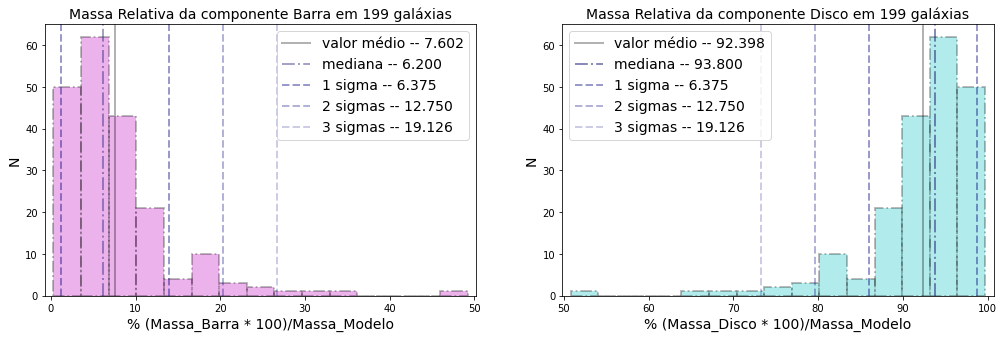

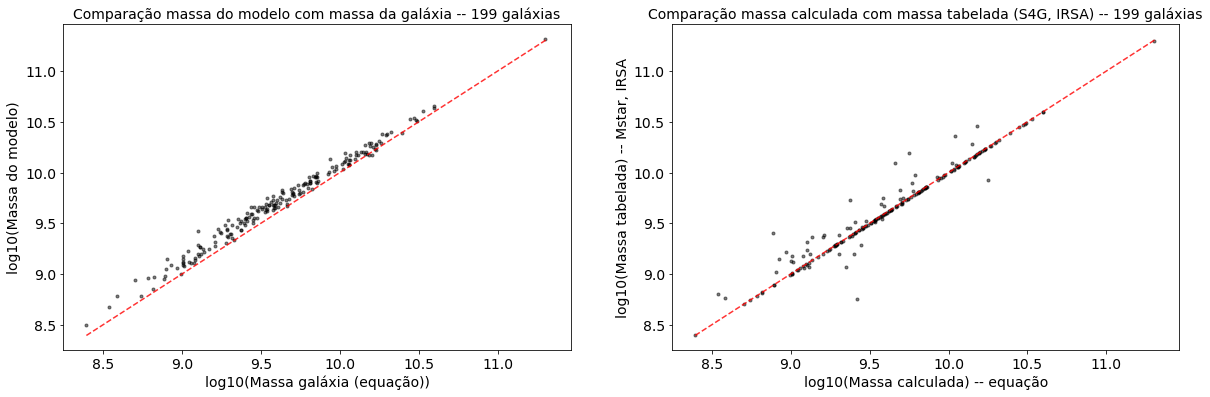

In [14]:
gals_dbar(tabela=amostra_430, plot=True, saveplot=True)

100%|█████████████████████████████████████████| 430/430 [00:05<00:00, 84.53it/s]


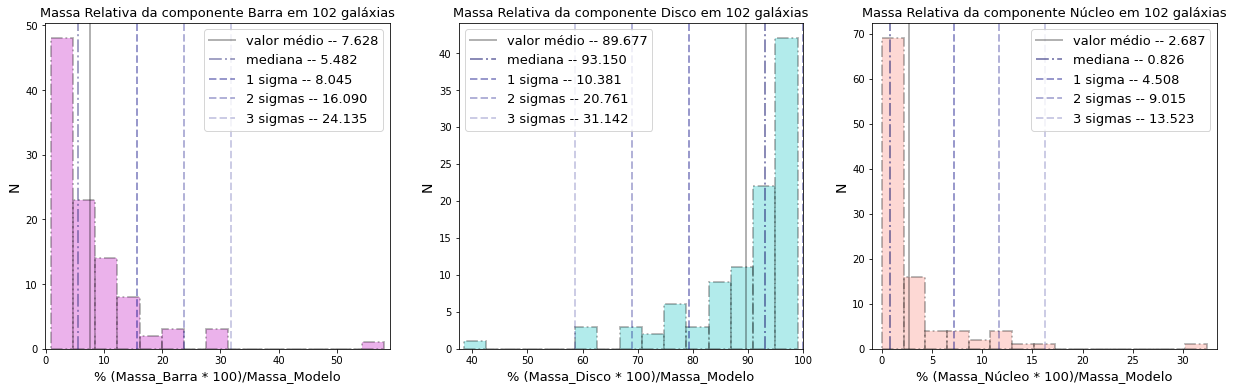

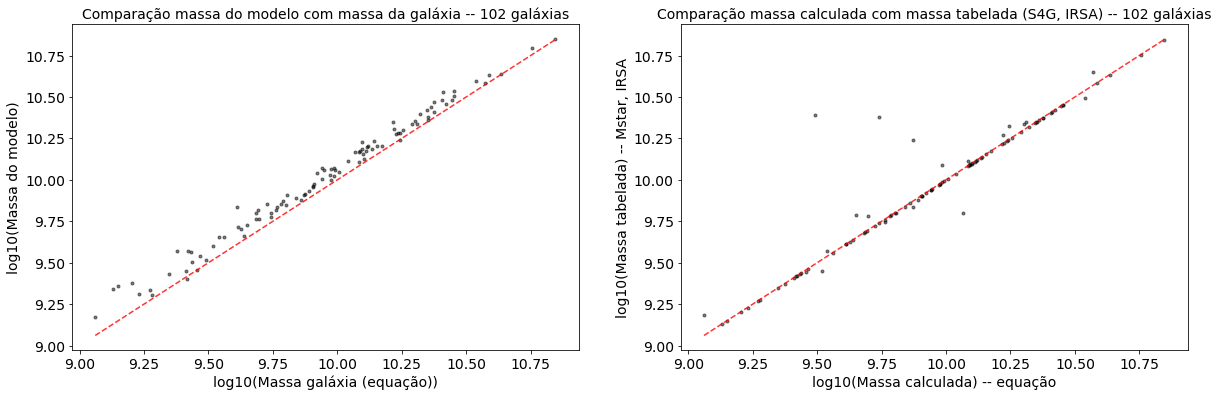

In [15]:
gals_dbarn(tabela=amostra_430, plot=True, saveplot=True)

100%|█████████████████████████████████████████| 430/430 [00:05<00:00, 80.01it/s]


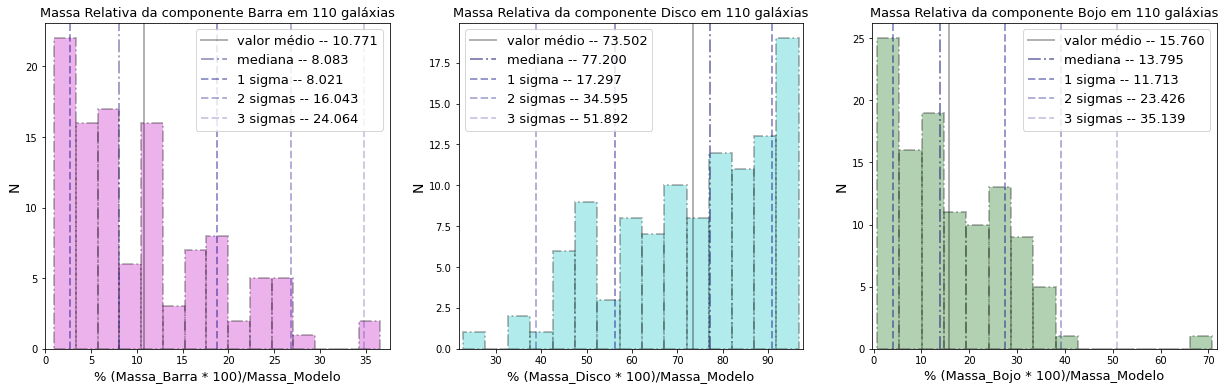

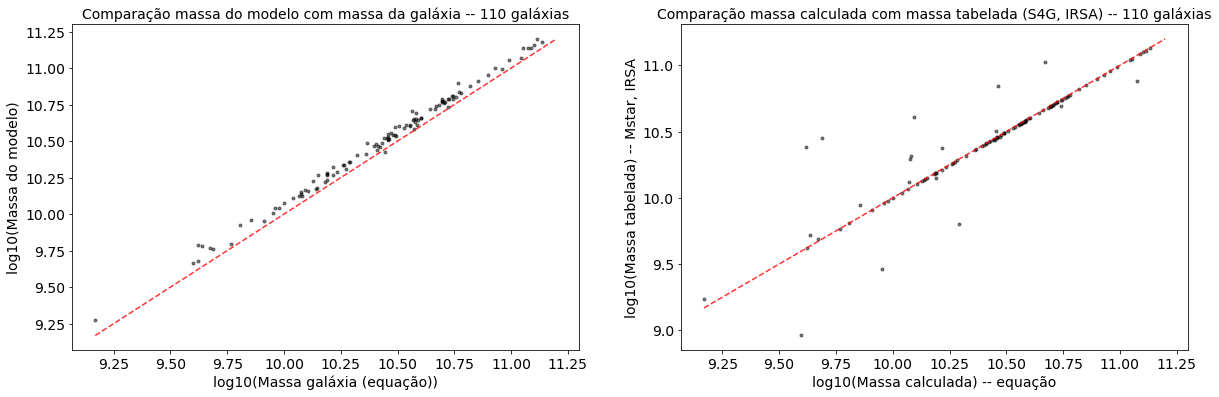

In [16]:
gals_bdbar(tabela=amostra_430, plot=True, saveplot=True)

100%|████████████████████████████████████████| 430/430 [00:00<00:00, 496.10it/s]


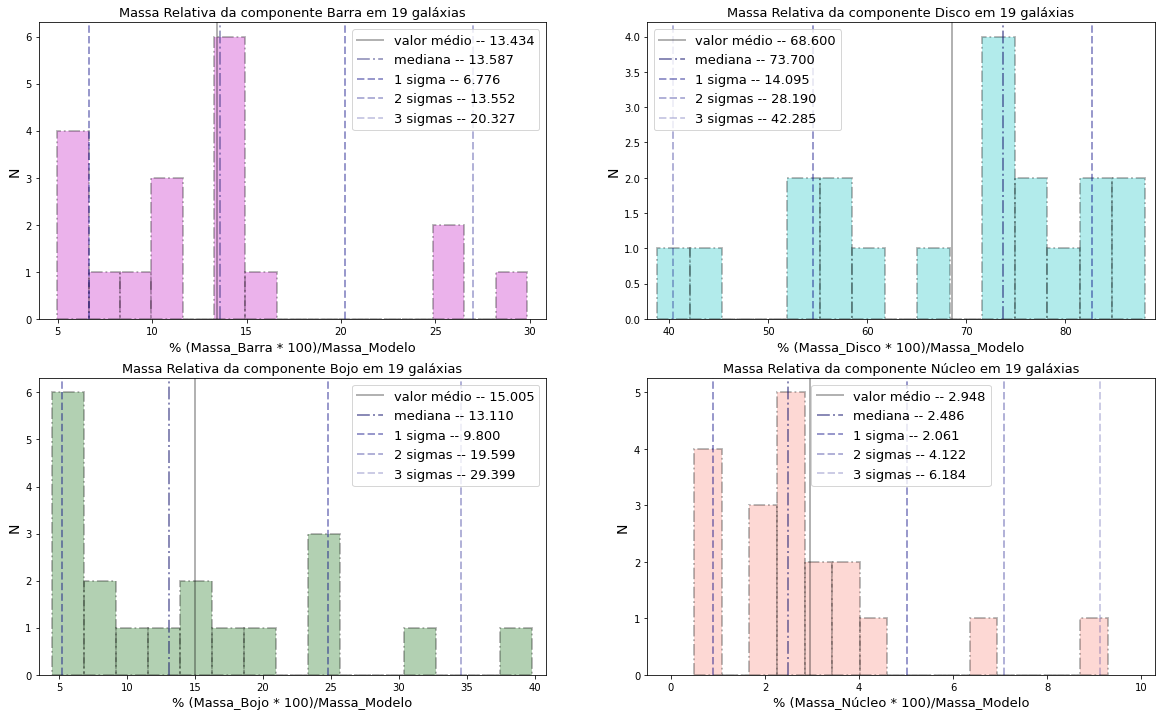

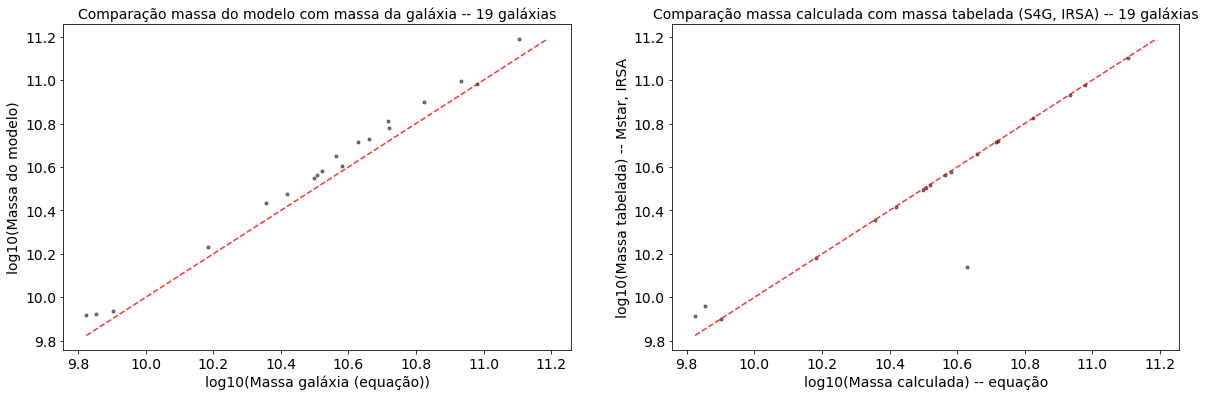

In [17]:
gals_bdbarn(tabela=amostra_430, plot=True, saveplot=True)

In [18]:
#Os cortes de massa -- Tabela amostra 430 galáxias

amostra_430_m9 = amostra_430[amostra_430.mstar < 9] #massa menor que 10^9 -- galáxias anãs

amostra_430_m9_m10 = amostra_430[amostra_430.mstar >= 9][amostra_430.mstar < 10] #massivas intermediarias

amostra_430_m10 = amostra_430[amostra_430.mstar >= 10] #muito massivas

amostra_430_m9m = amostra_430[amostra_430.mstar >= 9] #massivas

/tmp/ipykernel_94180/3765417023.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  amostra_430_m9_m10 = amostra_430[amostra_430.mstar >= 9][amostra_430.mstar < 10] #massivas intermediarias


### Galáxias anãs

Temos 12 galáxias com modelo dbar e 1 galaxia com modelo bdbar

In [19]:
amostra_430_m9[['Mod']].value_counts()

Mod    
_dbar      10
_dbarf      2
_bdbarf     1
dtype: int64

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 21.87it/s]


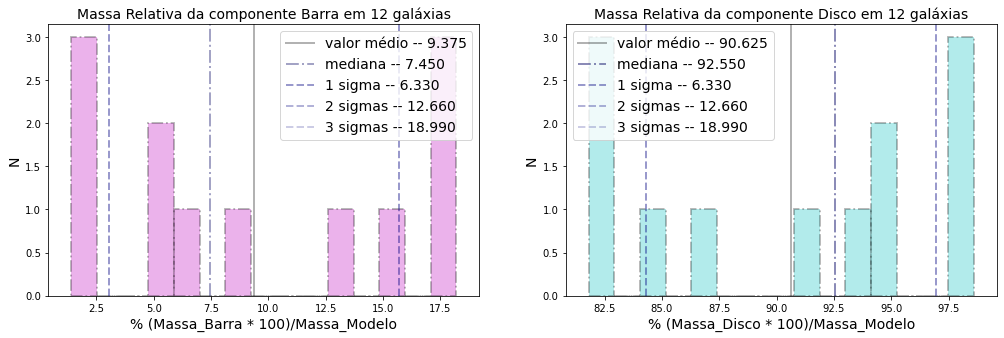

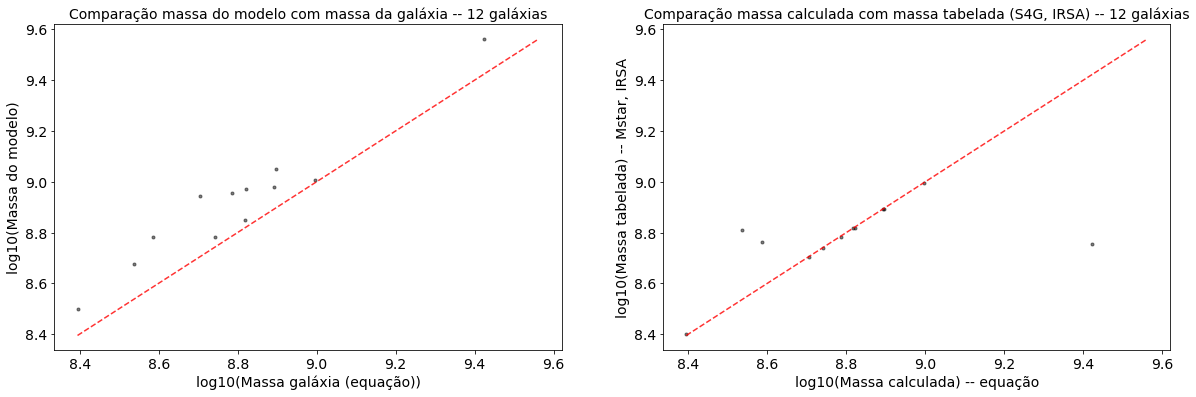

In [20]:
gals_dbar(tabela=amostra_430_m9.reset_index(), plot=True, saveplot=True)

100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 214.97it/s]


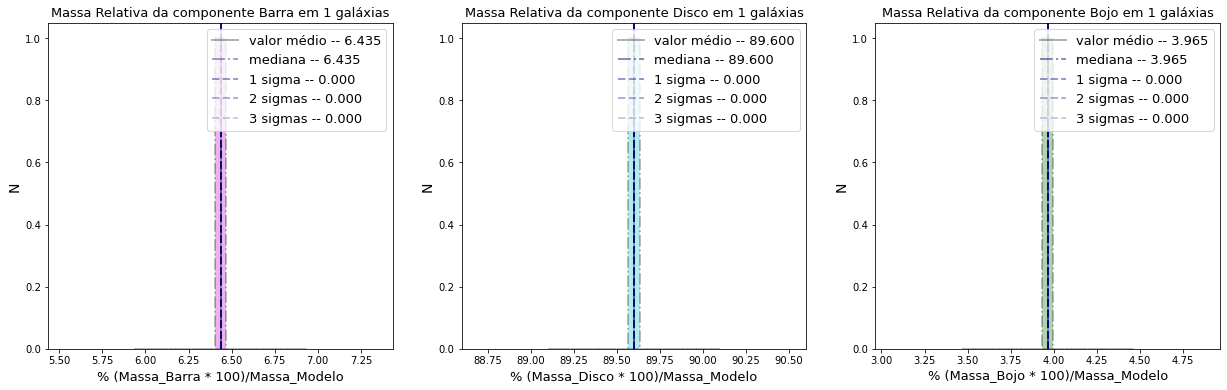

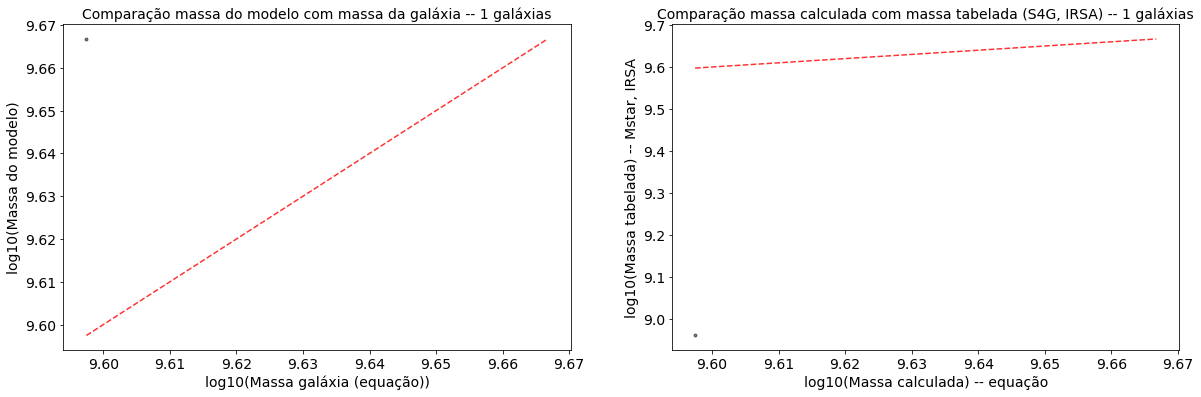

In [21]:
gals_bdbar(tabela=amostra_430_m9.reset_index(), plot=True, saveplot=True)

### Galáxias massivas

In [22]:
amostra_430_m9m[['Mod']].value_counts()

Mod     
_dbar       146
_bdbarf      58
_dbarn       55
_bdbar       51
_dbarf       41
_dbarfn      36
_bdbarfn     15
_ndbar        8
_bdbarn       3
_dbarnf       2
_dnbar        1
_nbdbar       1
dtype: int64

100%|█████████████████████████████████████████| 417/417 [00:09<00:00, 45.76it/s]


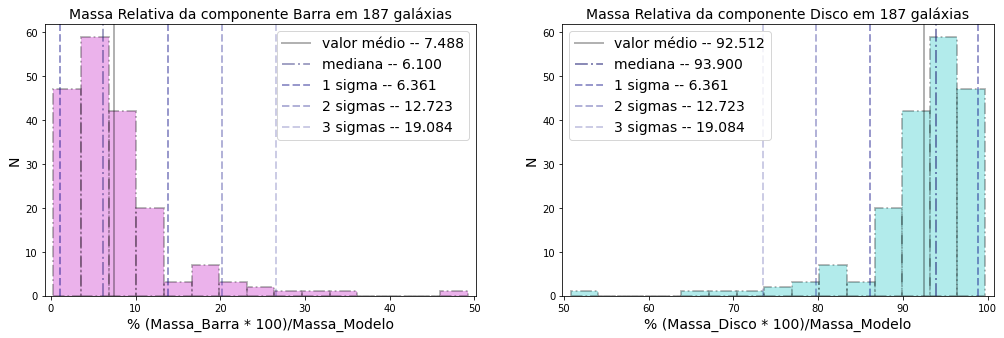

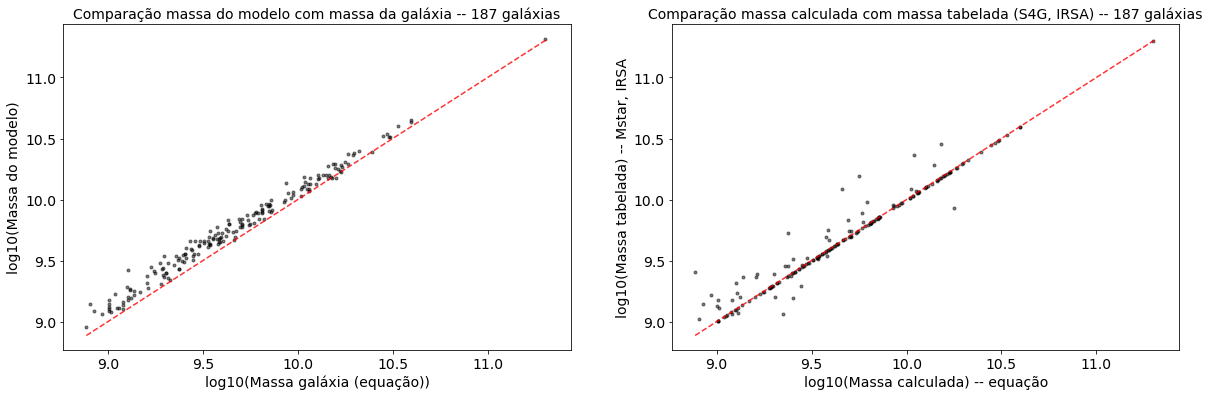

In [23]:
gals_dbar(tabela=amostra_430_m9m.reset_index(), plot=True, saveplot=True)

100%|█████████████████████████████████████████| 417/417 [00:05<00:00, 76.13it/s]


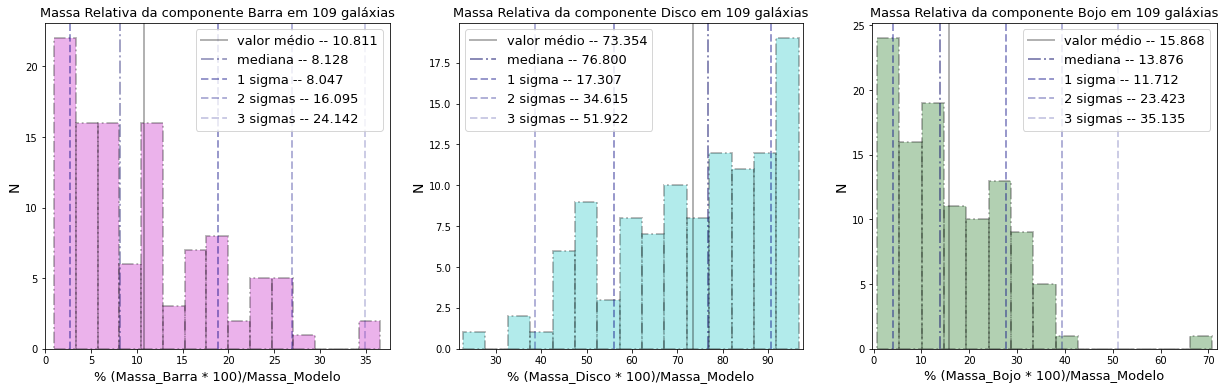

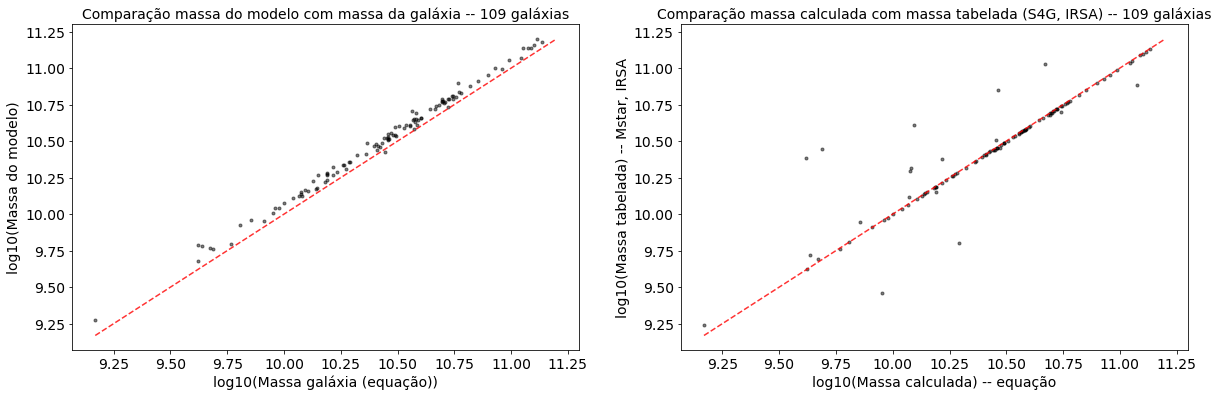

In [24]:
gals_bdbar(tabela=amostra_430_m9m.reset_index(), plot=True, saveplot=True)

100%|█████████████████████████████████████████| 417/417 [00:05<00:00, 80.02it/s]


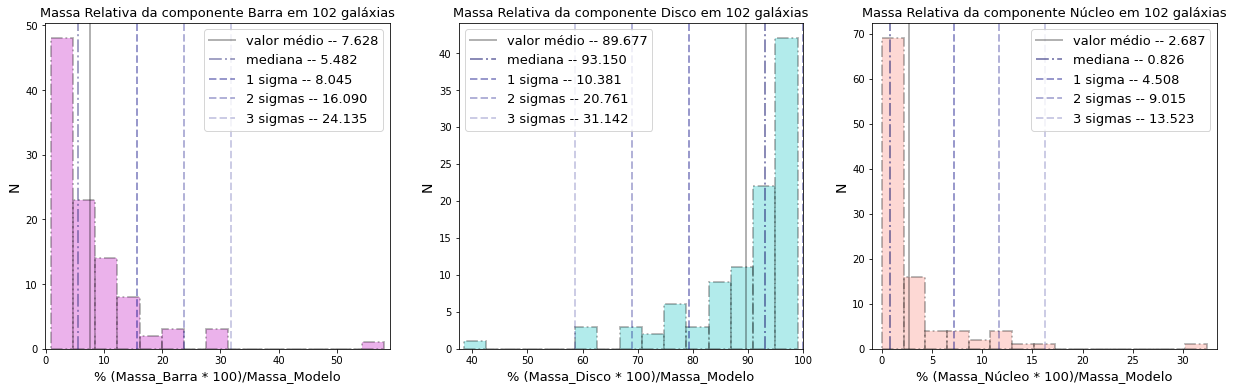

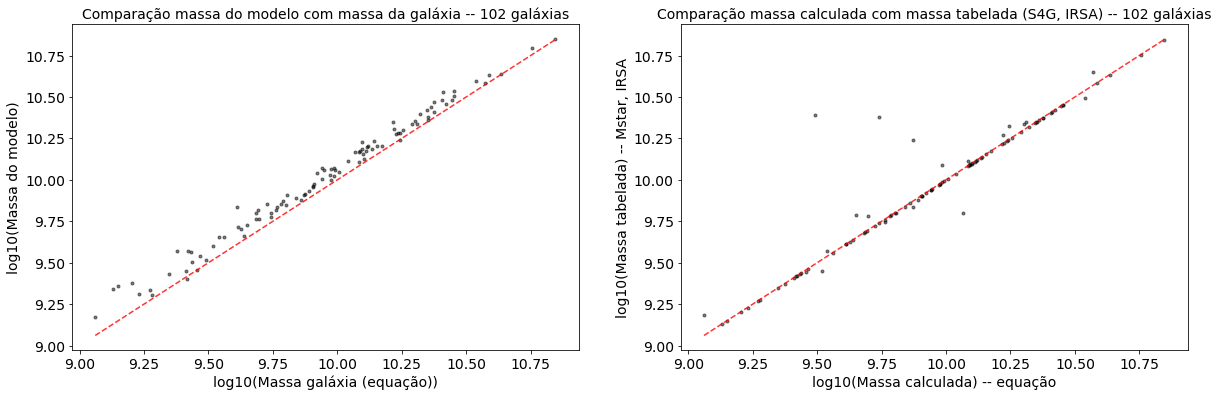

In [25]:
gals_dbarn(tabela=amostra_430_m9m.reset_index(), plot=True, saveplot=True)

100%|████████████████████████████████████████| 417/417 [00:00<00:00, 452.70it/s]


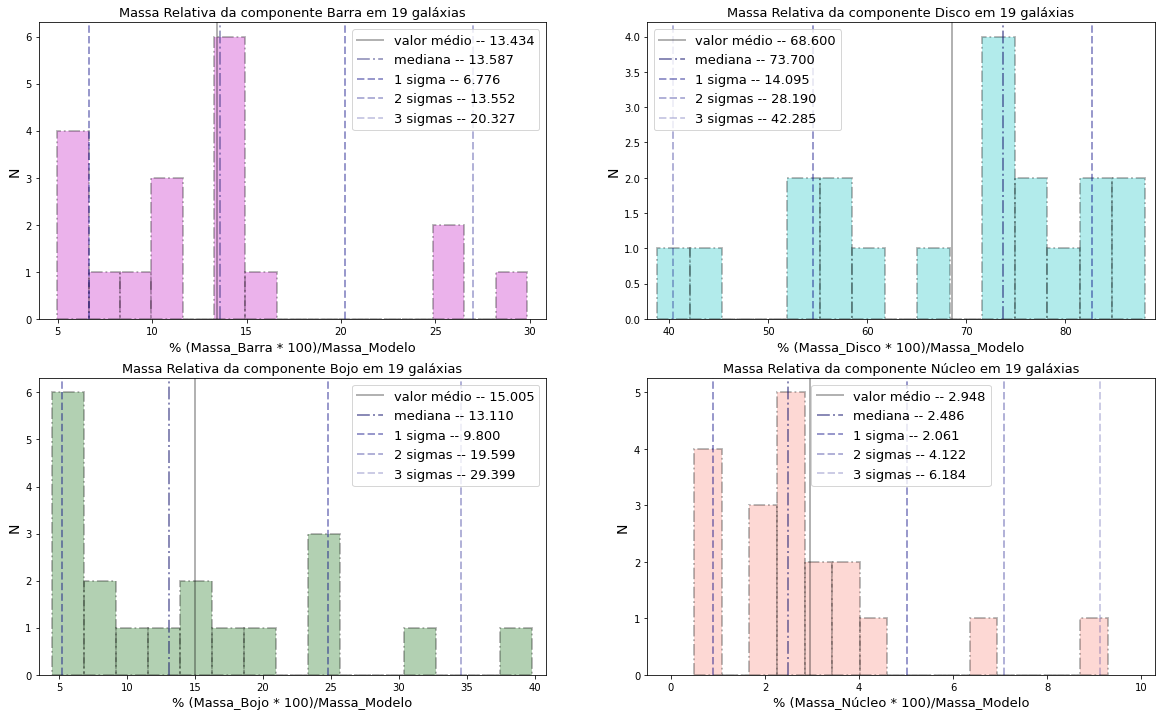

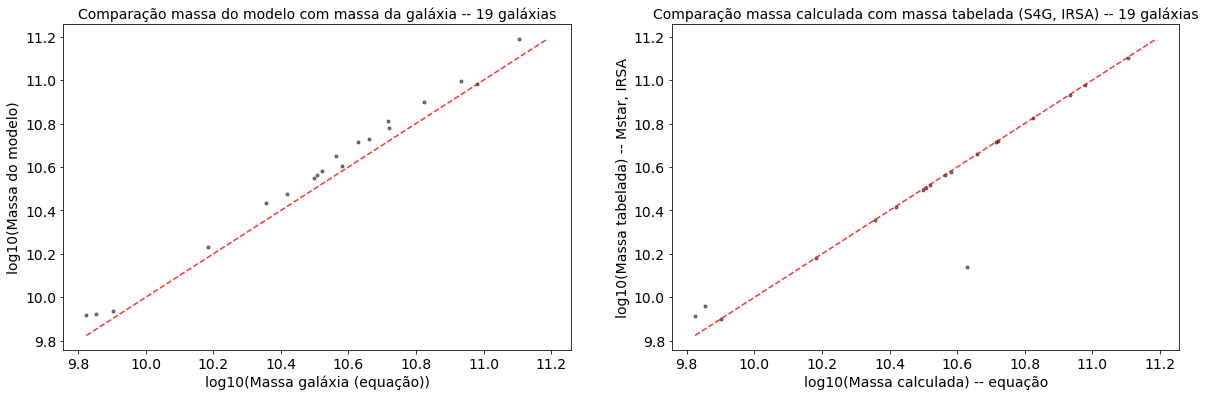

In [26]:
gals_bdbarn(tabela=amostra_430_m9m.reset_index(), plot=True, saveplot=True)

### Massivas intermediarias

100%|█████████████████████████████████████████| 208/208 [00:06<00:00, 30.26it/s]


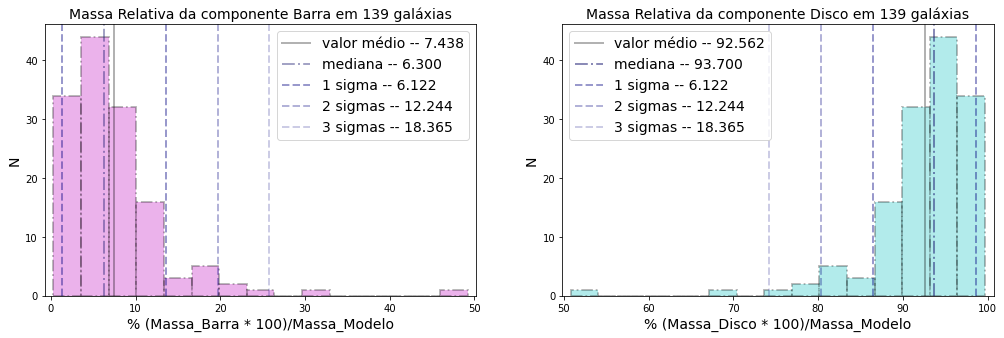

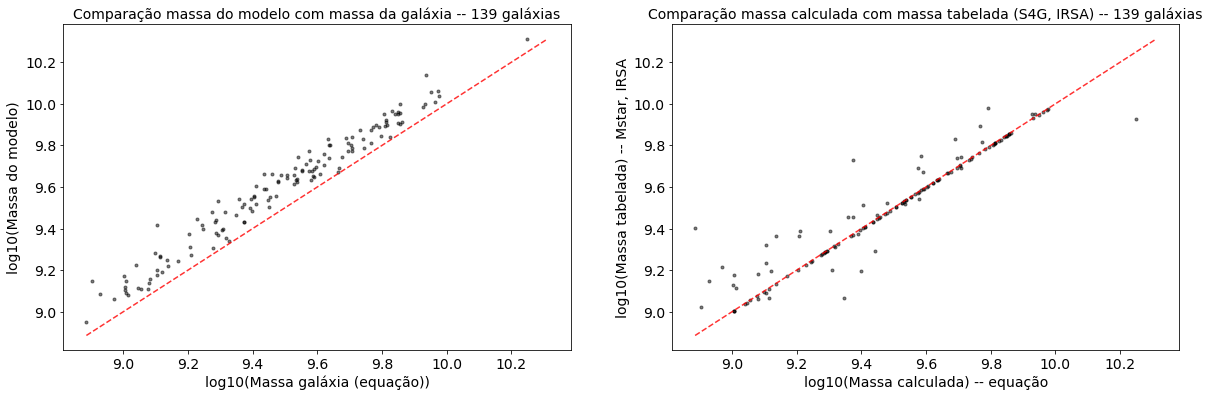

In [27]:
gals_dbar(tabela=amostra_430_m9_m10.reset_index(), plot=True, saveplot=True)

100%|████████████████████████████████████████| 208/208 [00:00<00:00, 327.43it/s]


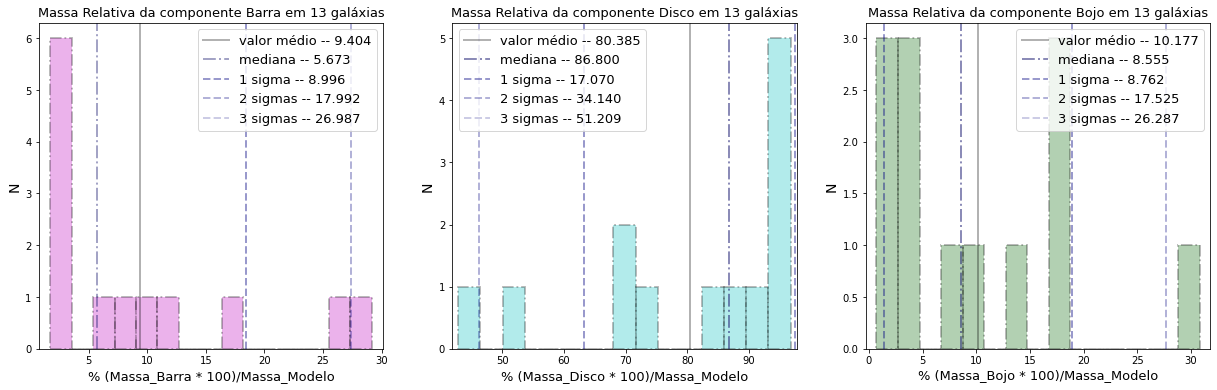

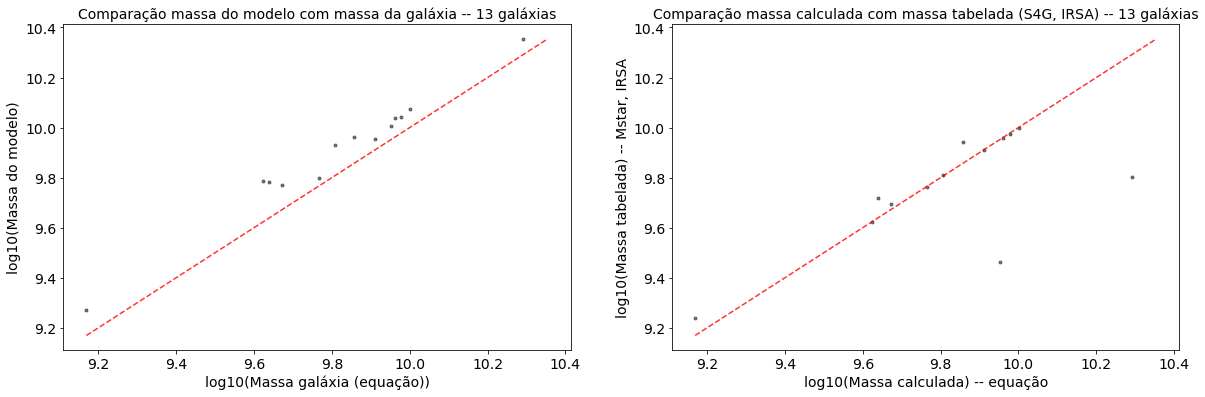

In [28]:
gals_bdbar(tabela=amostra_430_m9_m10.reset_index(), plot=True, saveplot=True)

100%|█████████████████████████████████████████| 208/208 [00:03<00:00, 68.28it/s]


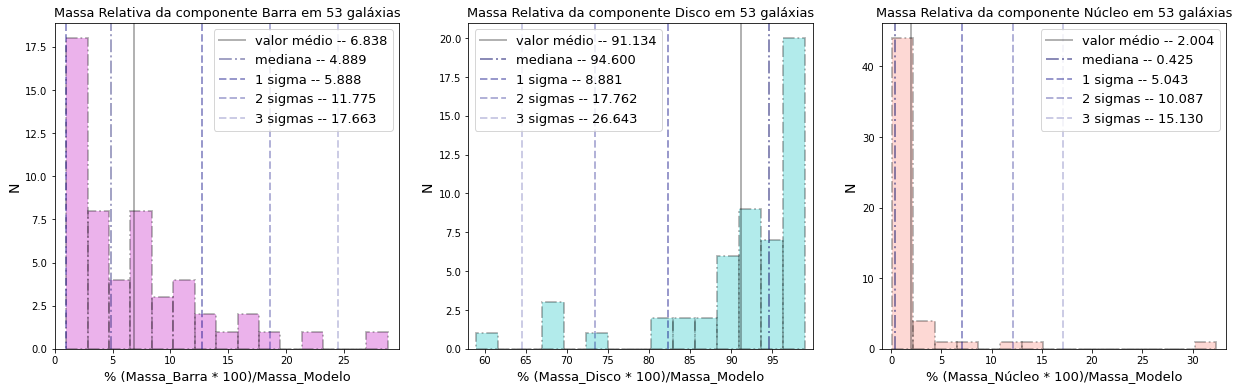

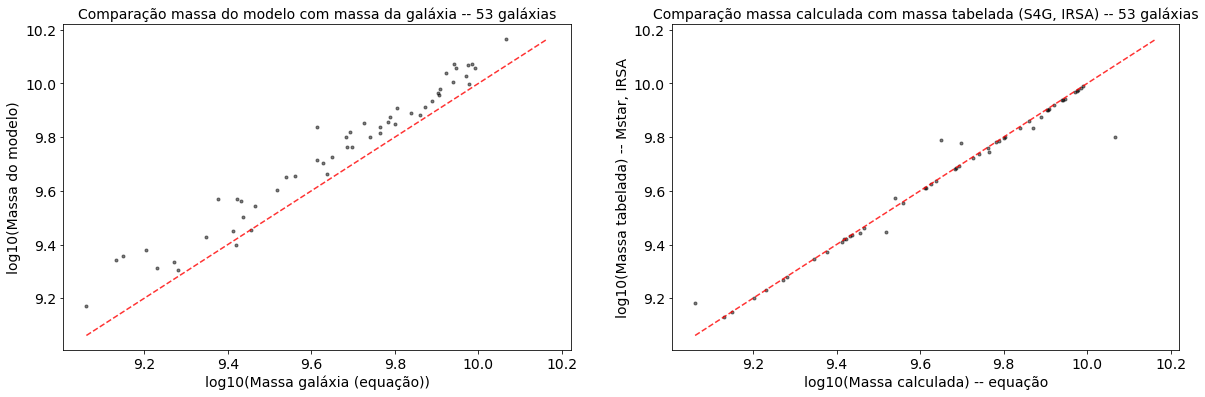

In [29]:
gals_dbarn(tabela=amostra_430_m9_m10.reset_index(), plot=True, saveplot=True)

100%|███████████████████████████████████████| 208/208 [00:00<00:00, 1191.12it/s]


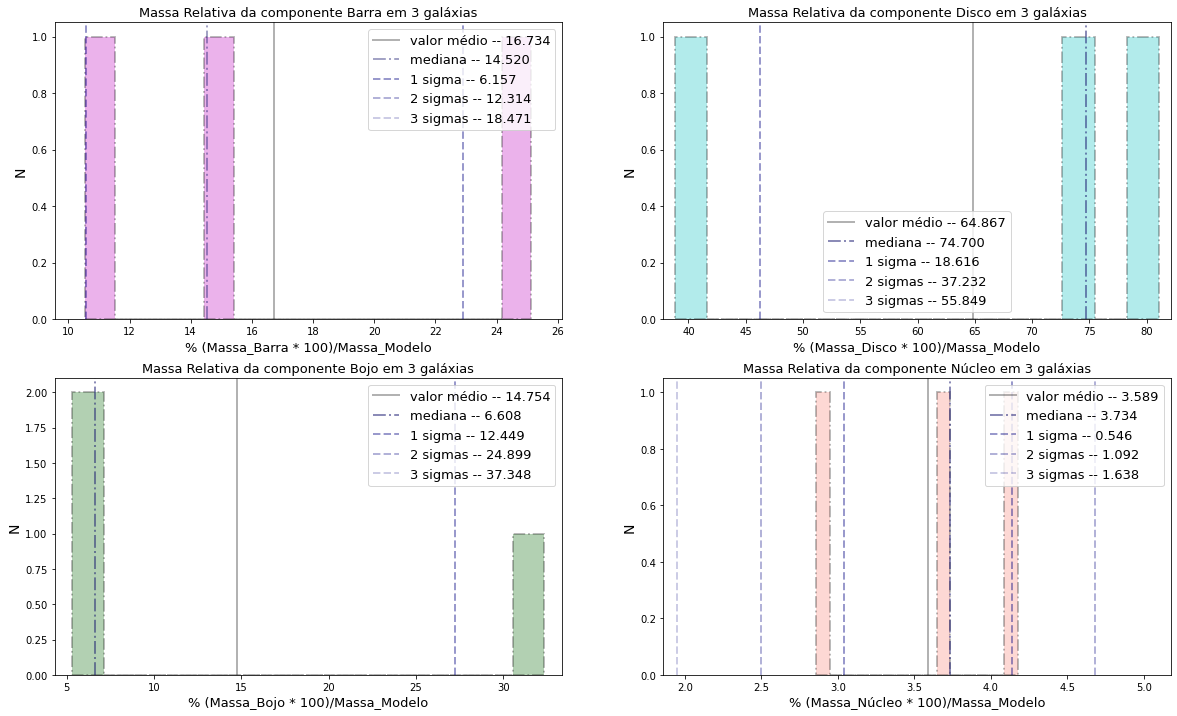

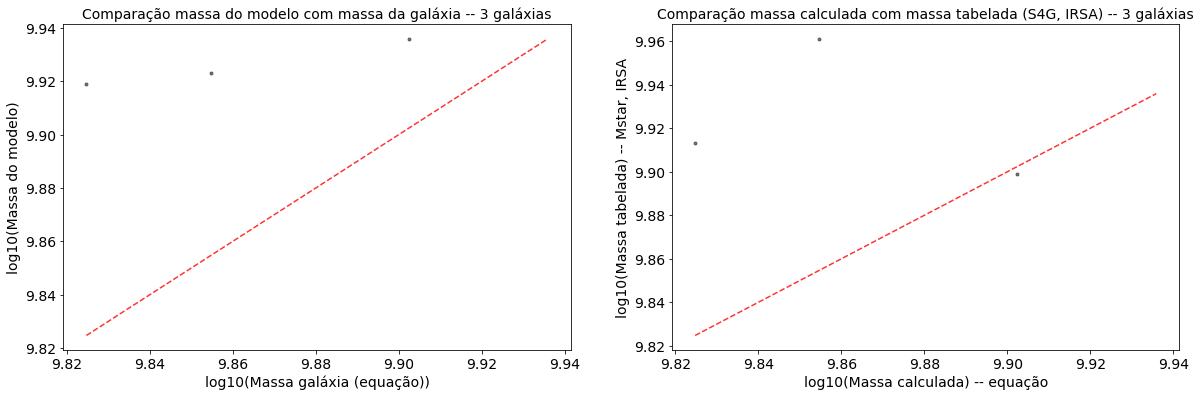

In [30]:
gals_bdbarn(tabela=amostra_430_m9_m10.reset_index(), plot=True, saveplot=True)

### Muito massivas

100%|█████████████████████████████████████████| 209/209 [00:02<00:00, 76.88it/s]


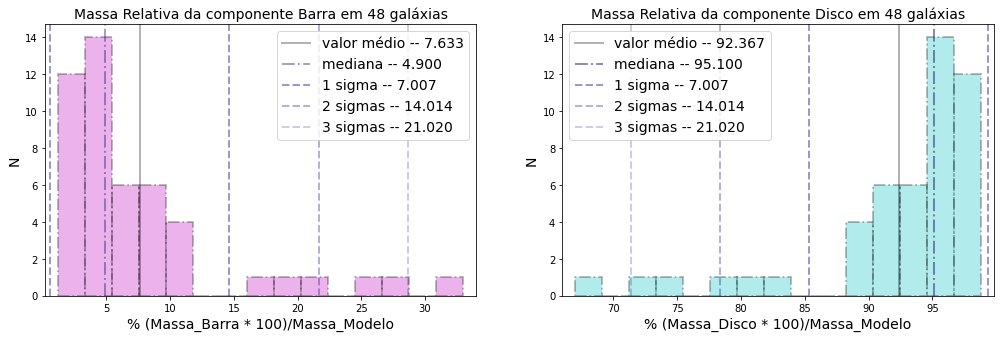

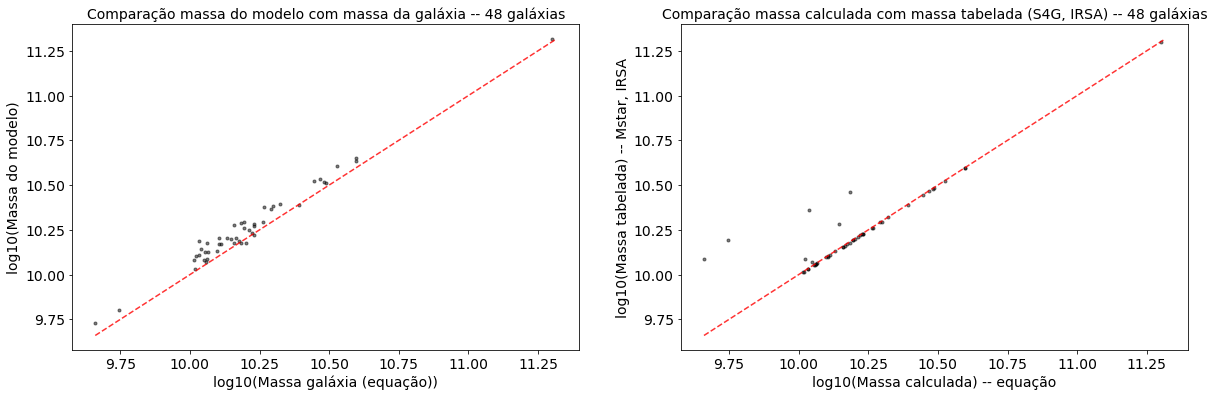

In [31]:
gals_dbar(tabela=amostra_430_m10.reset_index(), plot=True, saveplot=True)

100%|█████████████████████████████████████████| 209/209 [00:04<00:00, 45.15it/s]


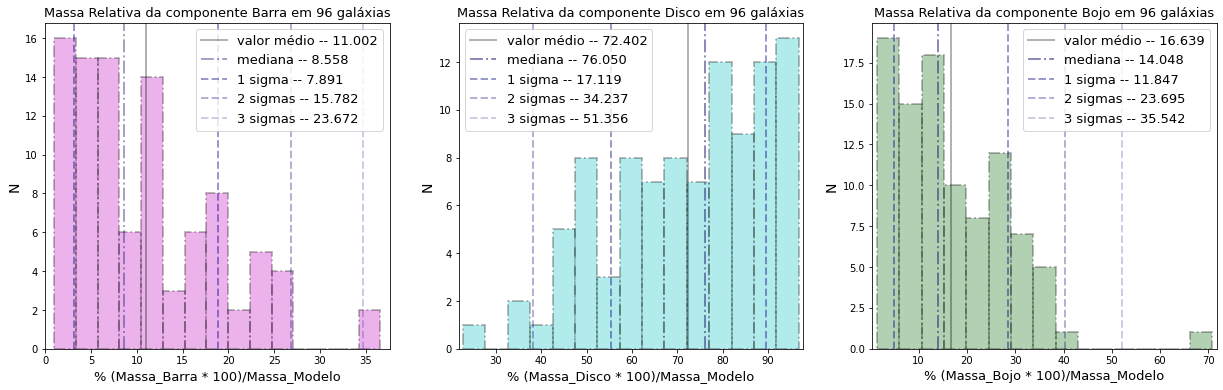

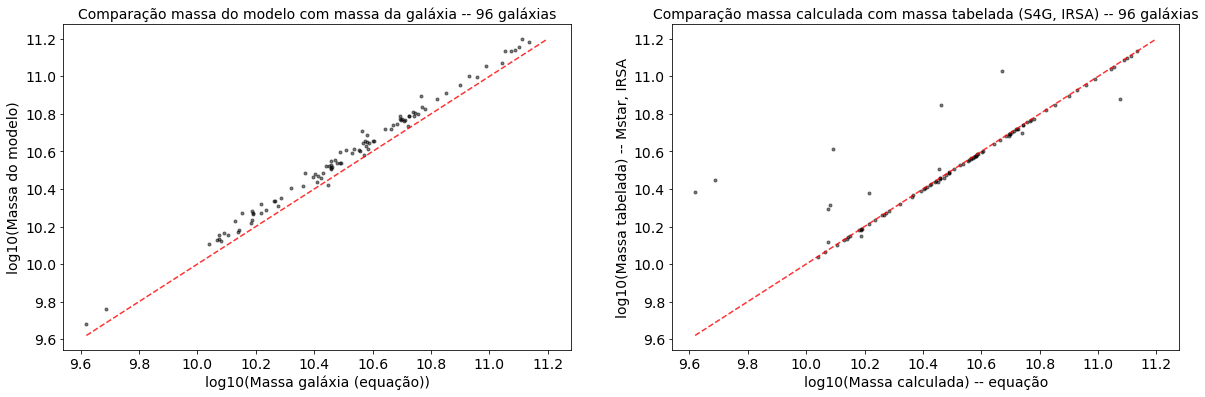

In [32]:
gals_bdbar(tabela=amostra_430_m10.reset_index(), plot=True, saveplot=True)

100%|█████████████████████████████████████████| 209/209 [00:02<00:00, 77.73it/s]


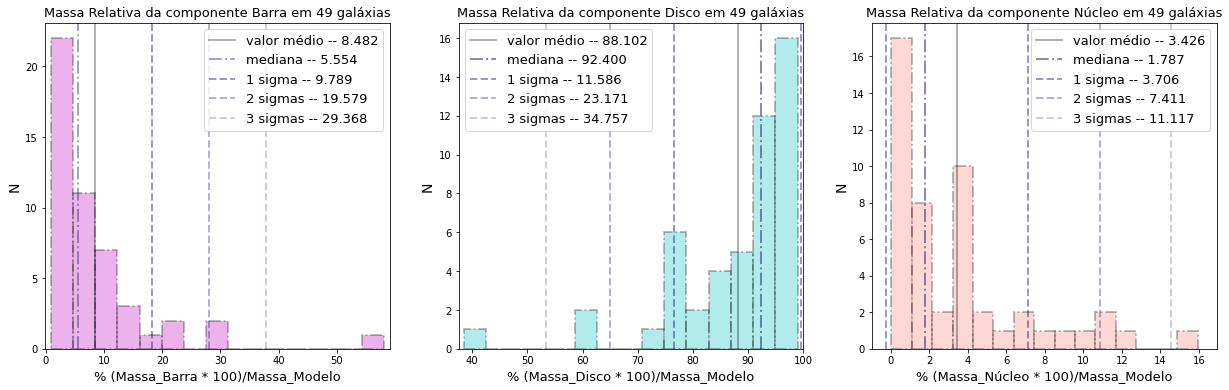

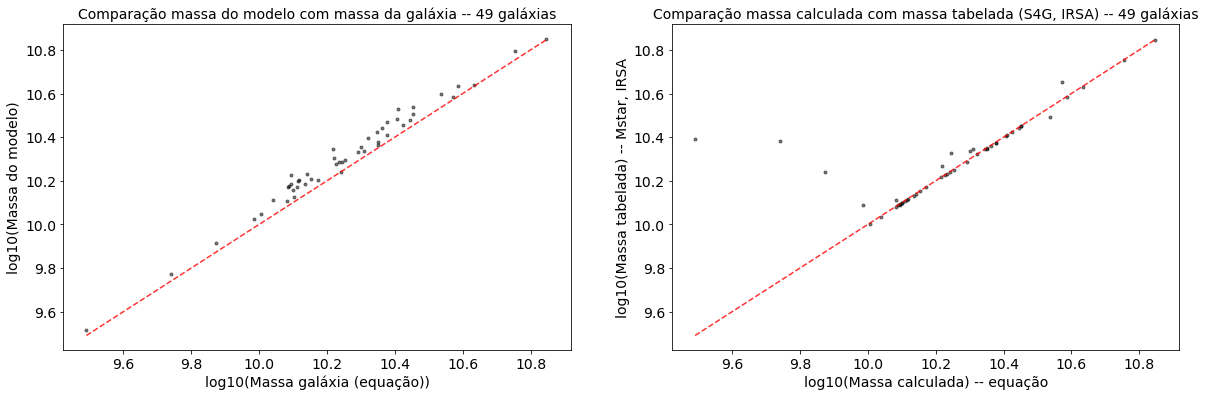

In [33]:
gals_dbarn(tabela=amostra_430_m10.reset_index(), plot=True, saveplot=True)

100%|████████████████████████████████████████| 209/209 [00:00<00:00, 243.21it/s]


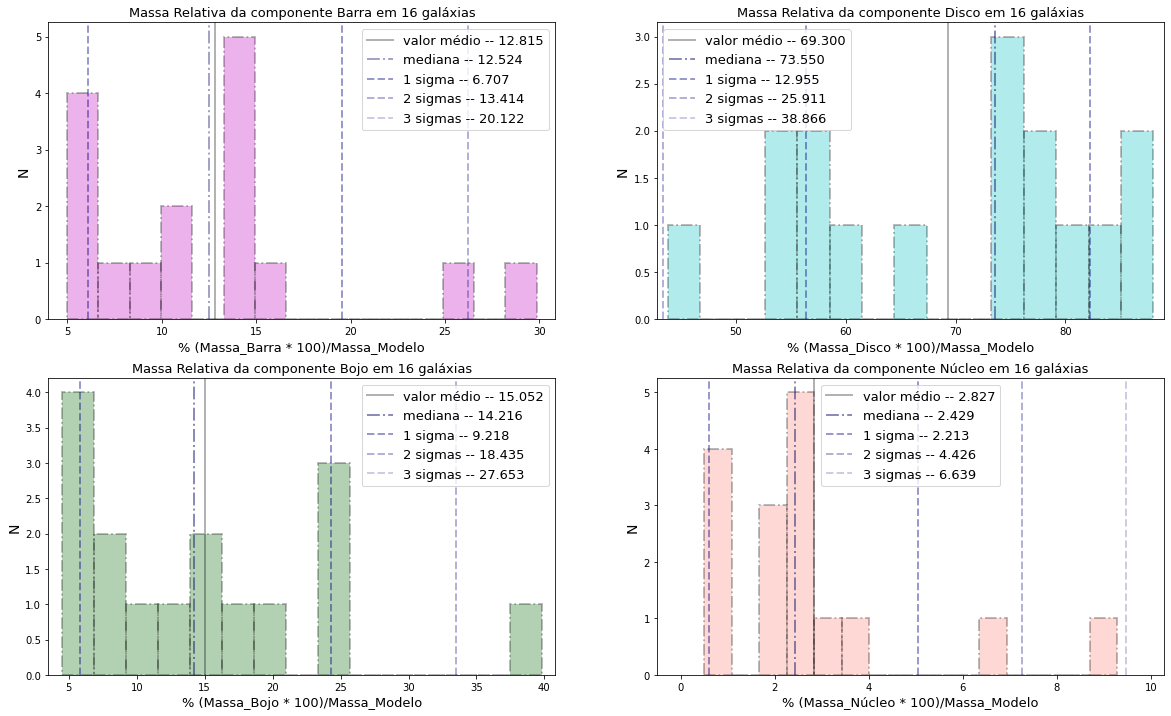

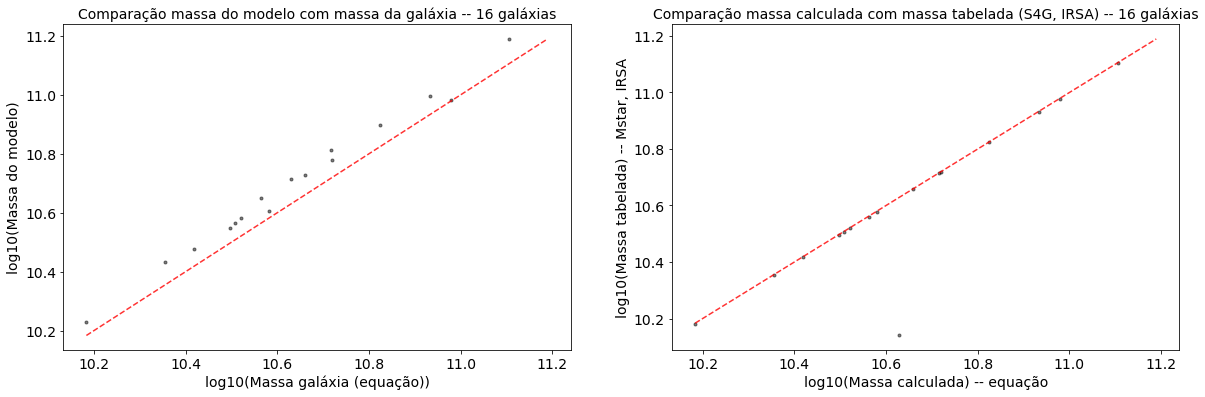

In [34]:
gals_bdbarn(tabela=amostra_430_m10.reset_index(), plot=True, saveplot=True)

### Espirais massivas

In [35]:
espirais_mass = amostra_430_m9m[amostra_430_m9m['__T_'] >= 0][amostra_430_m9m['__T_'] <= 7] #massivas

/tmp/ipykernel_94180/1470063602.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  espirais_mass = amostra_430_m9m[amostra_430_m9m['__T_'] >= 0][amostra_430_m9m['__T_'] <= 7] #massivas


100%|█████████████████████████████████████████| 273/273 [00:04<00:00, 67.36it/s]


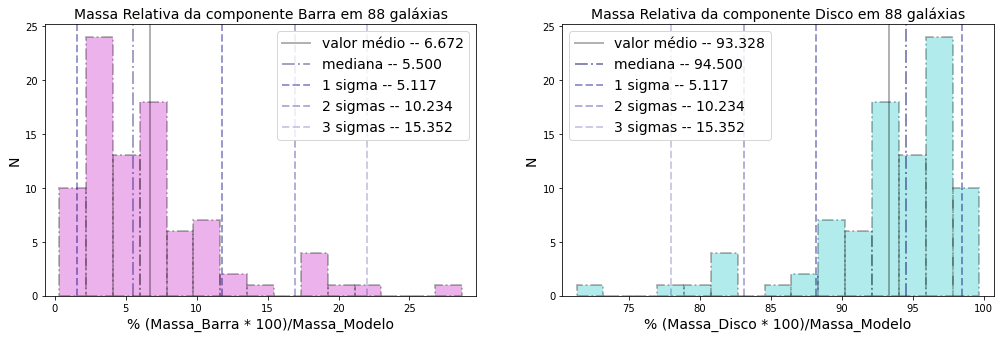

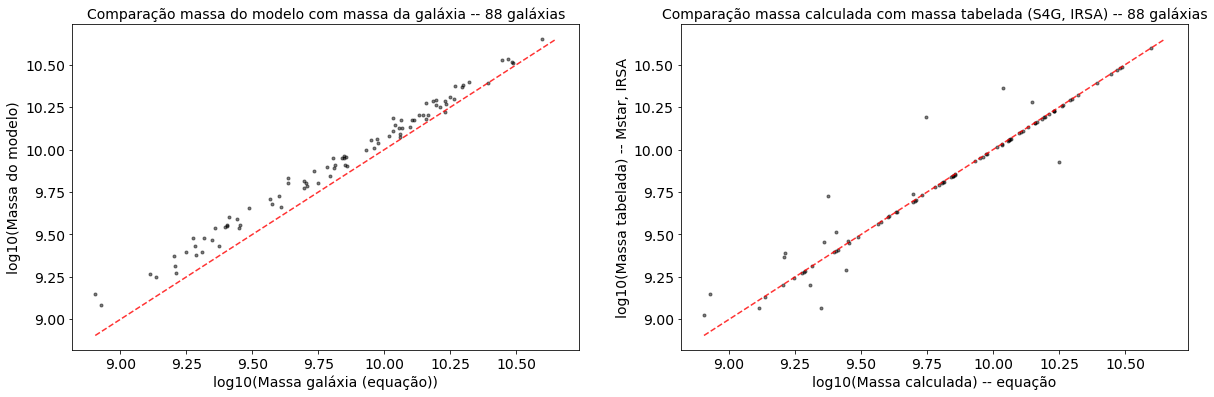

In [36]:
gals_dbar(tabela=espirais_mass.reset_index(), plot=True, saveplot=True)

100%|█████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


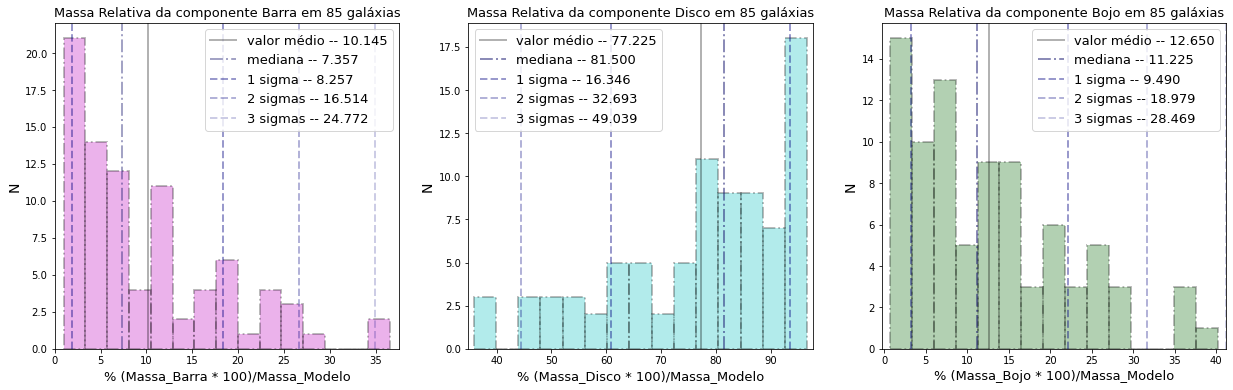

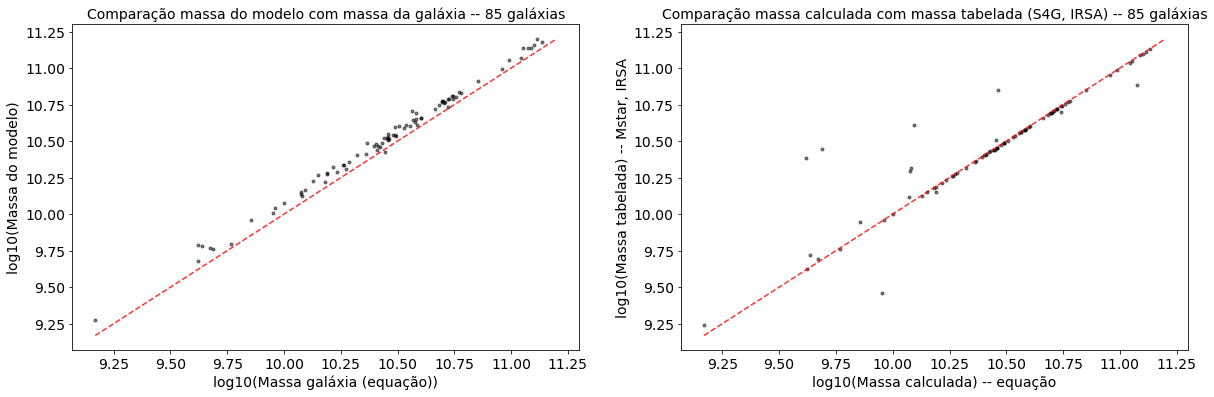

In [37]:
gals_bdbar(tabela=espirais_mass.reset_index(), plot=True, saveplot=True)

### Galáxias com componente BAR e de fato barradas

100%|█████████████████████████████████████████| 371/371 [00:09<00:00, 40.59it/s]


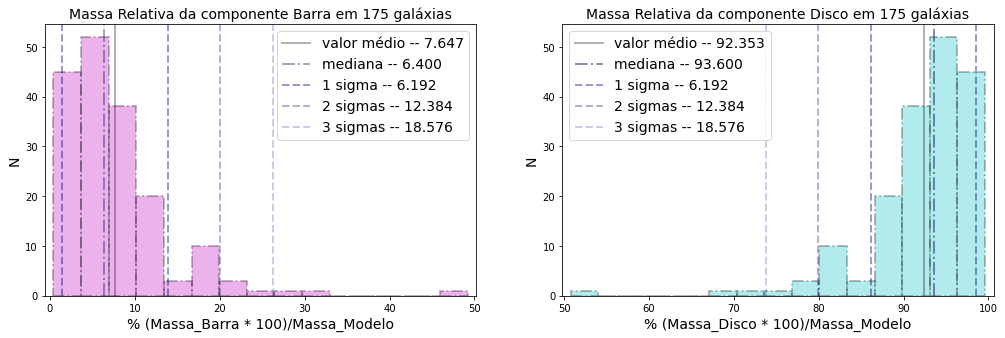

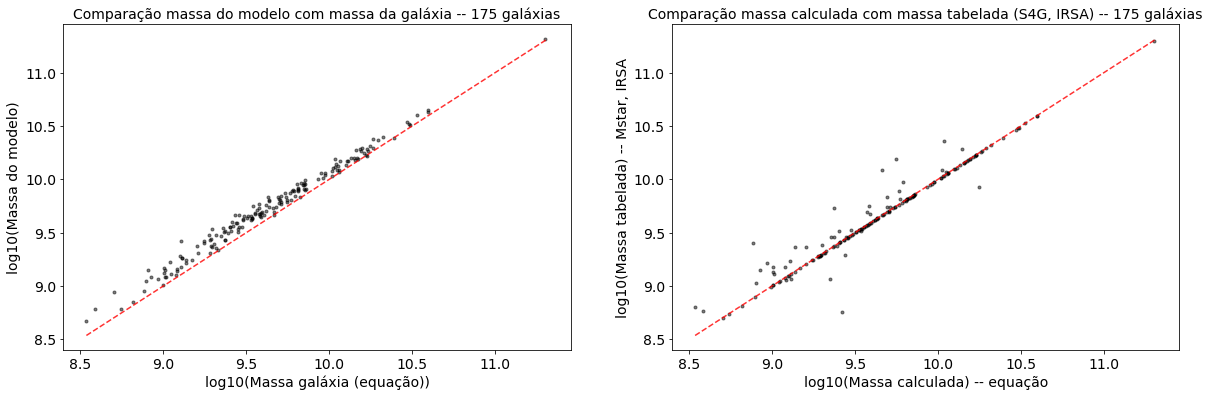

In [38]:
mask = amostra_430['__F_'] >= 0.50 #mascara para olhar as barras

#Modelo Disco+Barra
gals_dbar(tabela=amostra_430[mask].reset_index(), plot=True, saveplot=True)

100%|█████████████████████████████████████████| 371/371 [00:04<00:00, 90.34it/s]


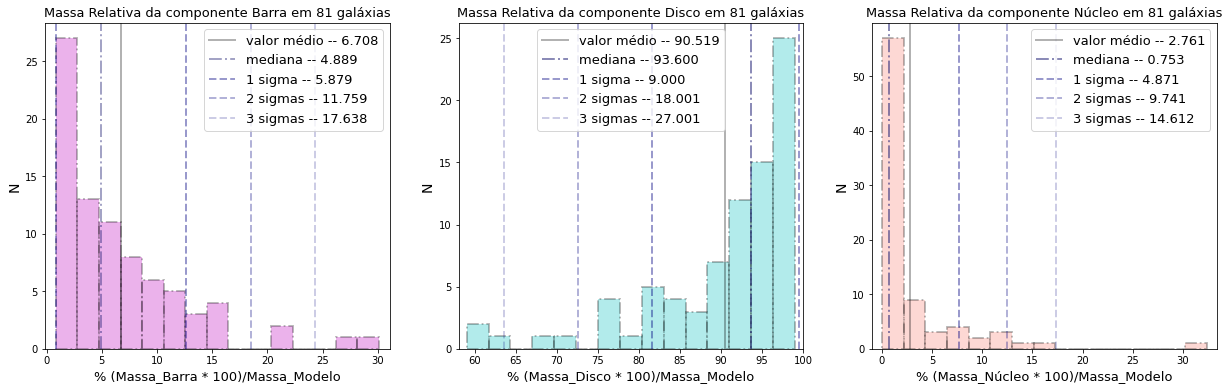

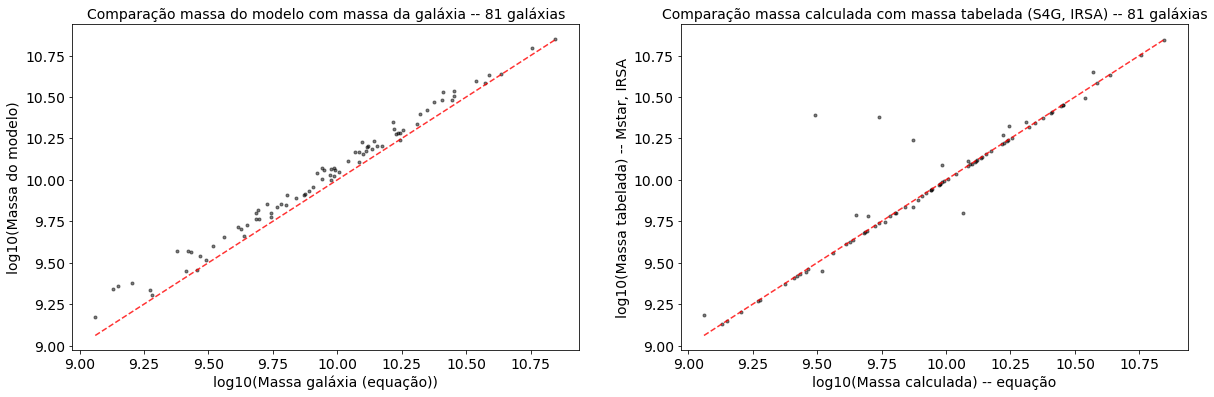

In [39]:
gals_dbarn(tabela=amostra_430[mask].reset_index(), plot=True, saveplot=True)

100%|█████████████████████████████████████████| 371/371 [00:04<00:00, 74.43it/s]


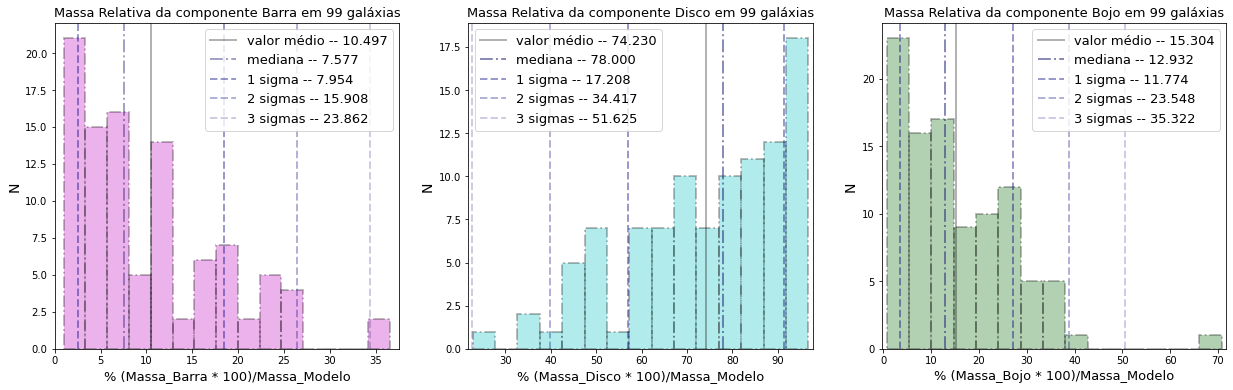

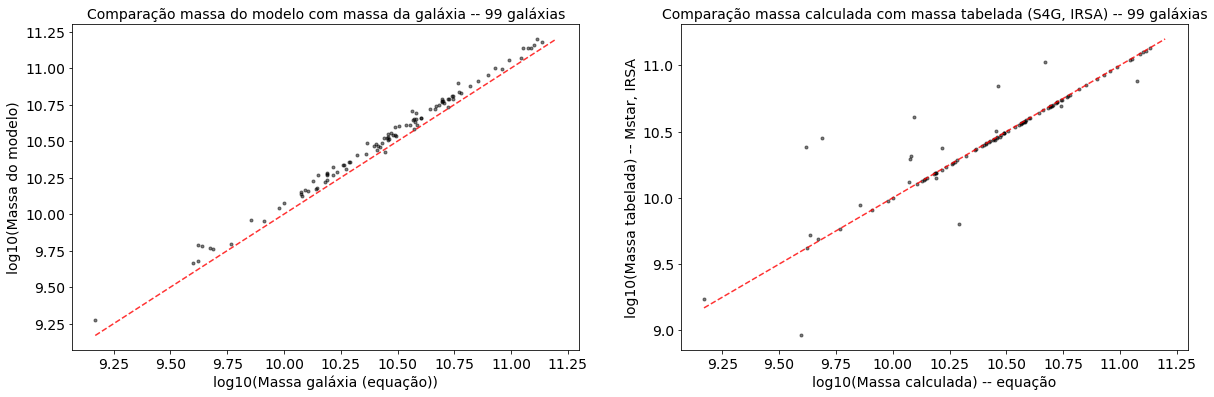

In [40]:
gals_bdbar(tabela=amostra_430[mask].reset_index(), plot=True, saveplot=True)

100%|████████████████████████████████████████| 371/371 [00:00<00:00, 440.46it/s]


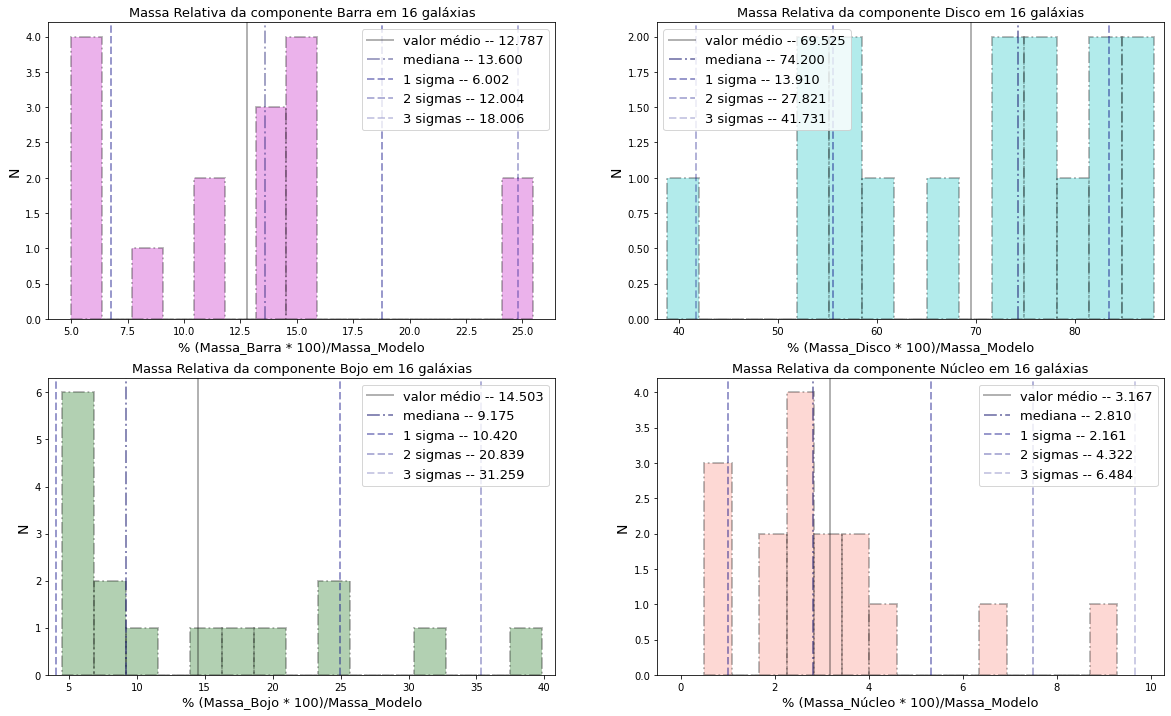

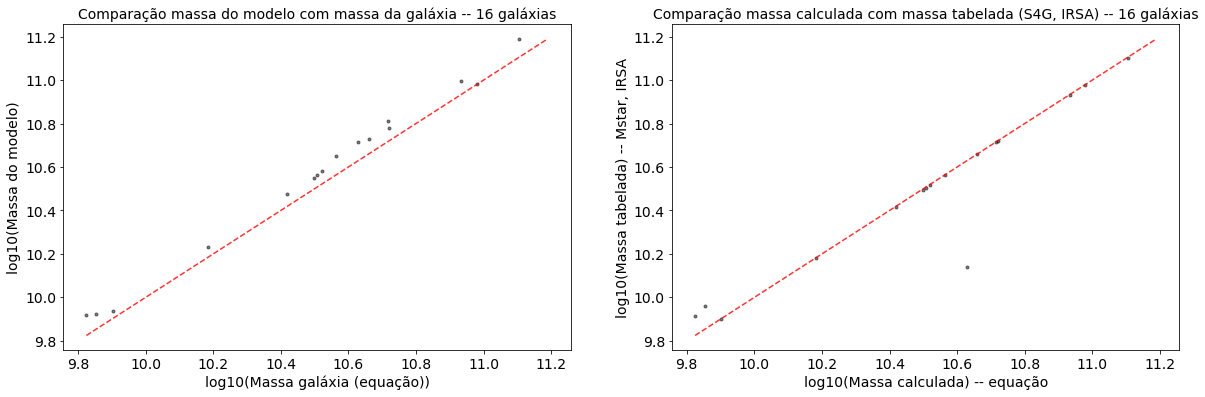

In [41]:
gals_bdbarn(tabela=amostra_430[mask].reset_index(), plot=True, saveplot=True)

/tmp/ipykernel_94180/3795389791.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gals_dbar(tabela=amostra_430_m9_m10[mask].reset_index(), plot=True, saveplot=True)
100%|█████████████████████████████████████████| 180/180 [00:06<00:00, 28.30it/s]


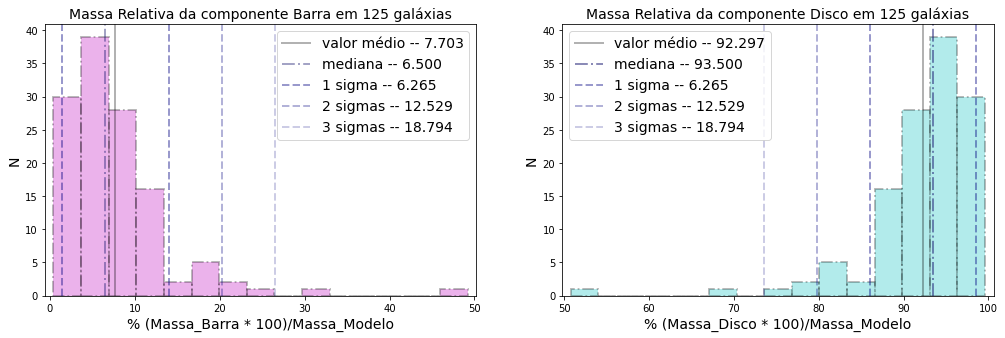

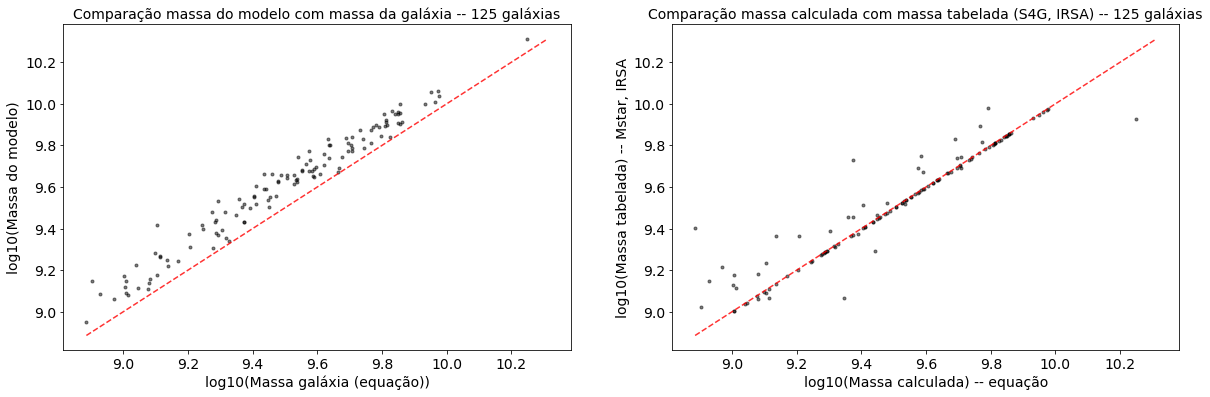

In [42]:
#massivas intermediárias
gals_dbar(tabela=amostra_430_m9_m10[mask].reset_index(), plot=True, saveplot=True)

/tmp/ipykernel_94180/1200806768.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gals_dbarn(tabela=amostra_430_m9_m10[mask].reset_index(), plot=True, saveplot=True)
100%|█████████████████████████████████████████| 180/180 [00:02<00:00, 76.69it/s]


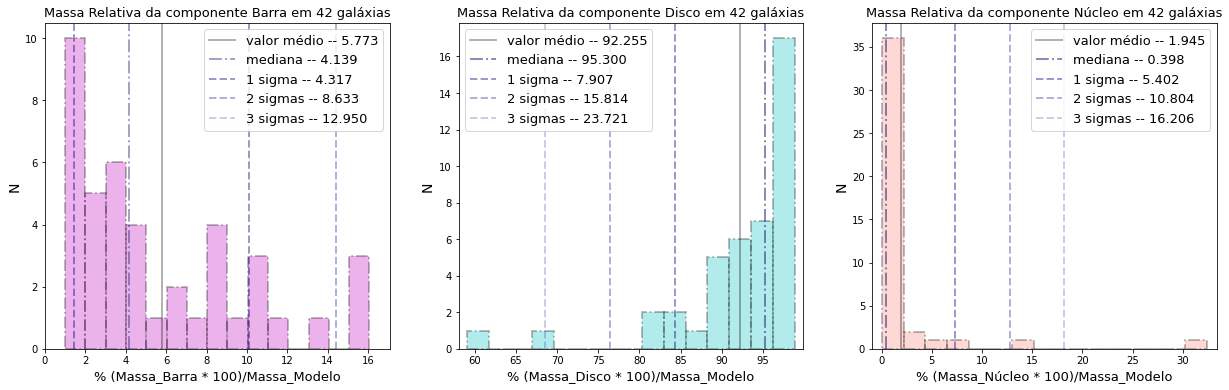

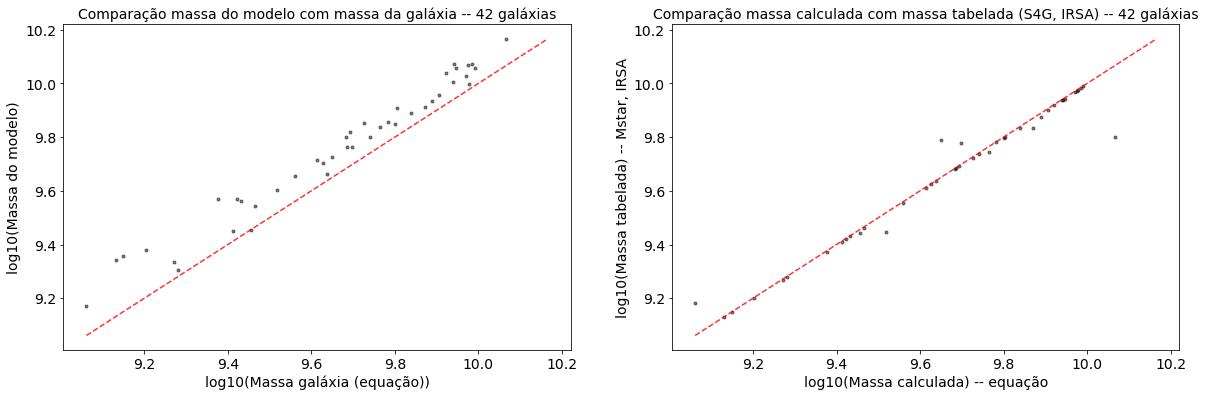

In [43]:
#massivas intermediárias
gals_dbarn(tabela=amostra_430_m9_m10[mask].reset_index(), plot=True, saveplot=True)

/tmp/ipykernel_94180/1018084566.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gals_bdbar(tabela=amostra_430_m9_m10[mask].reset_index(), plot=True, saveplot=True)
100%|████████████████████████████████████████| 180/180 [00:00<00:00, 369.62it/s]


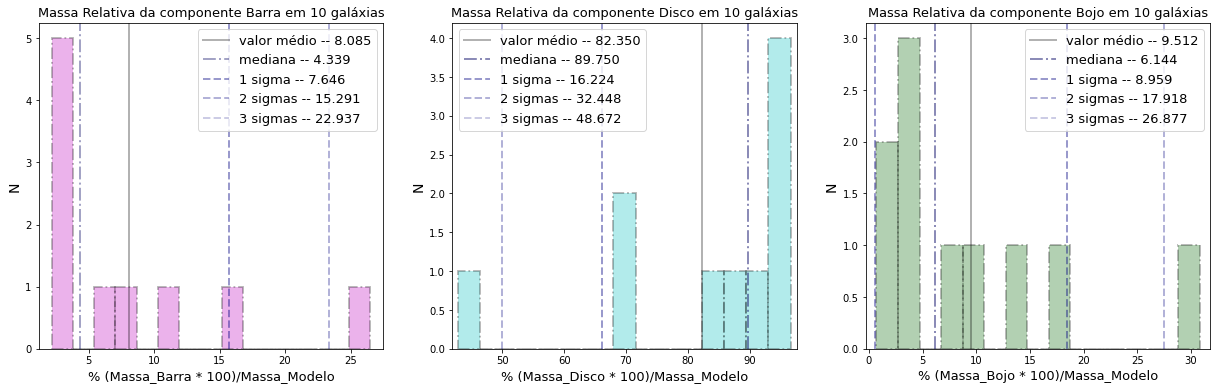

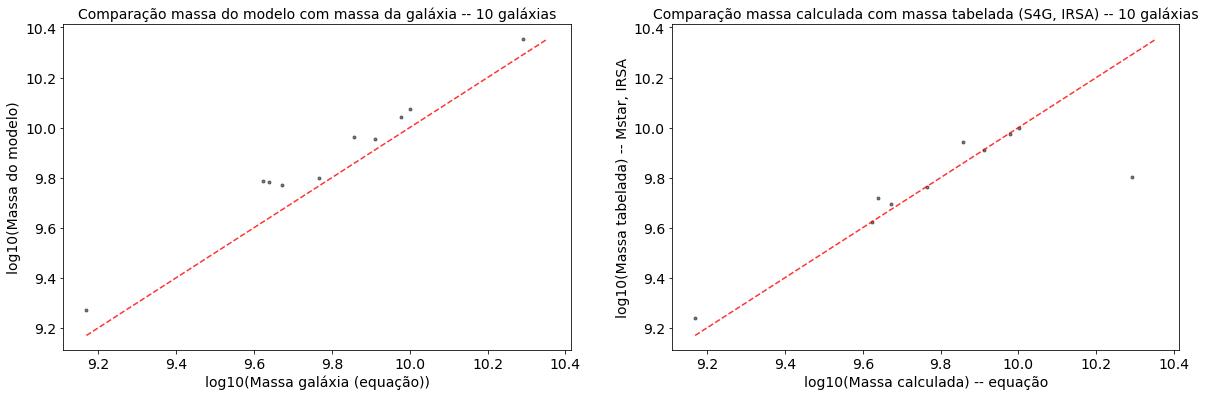

In [44]:
#massivas intermediárias
gals_bdbar(tabela=amostra_430_m9_m10[mask].reset_index(), plot=True, saveplot=True)

/tmp/ipykernel_94180/2400039984.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gals_bdbarn(tabela=amostra_430_m9_m10[mask].reset_index(), plot=True, saveplot=True)
100%|████████████████████████████████████████| 180/180 [00:00<00:00, 939.53it/s]


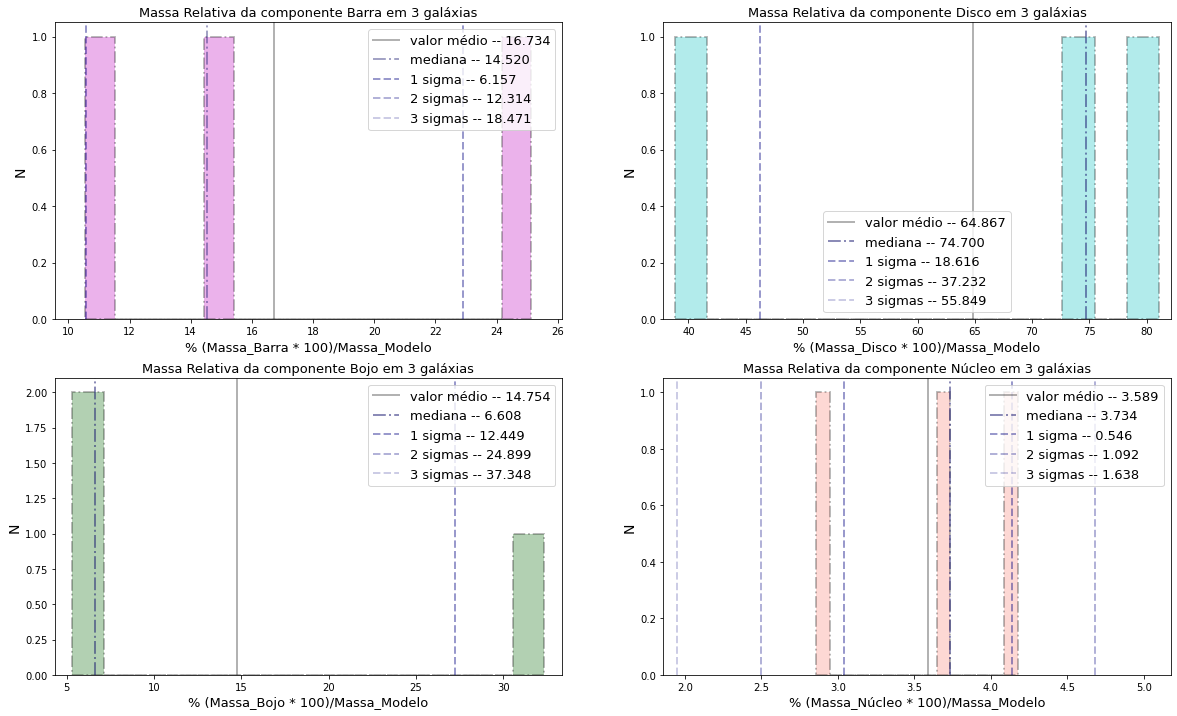

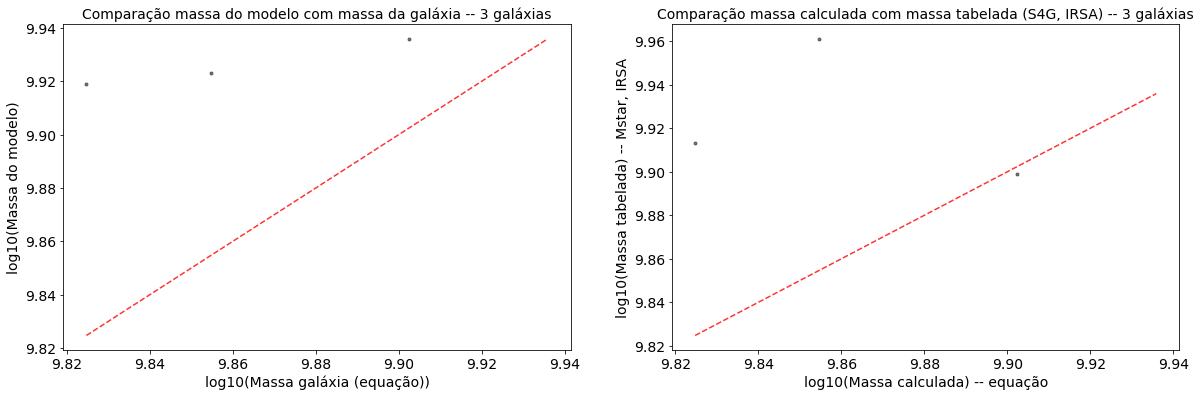

In [45]:
#massivas intermediárias
gals_bdbarn(tabela=amostra_430_m9_m10[mask].reset_index(), plot=True, saveplot=True)

In [46]:
#Lista com todas as massas relativas das galáxias massivas intermediárias
MBAR_MassInt = gals_dbar(tabela=amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_dbarn(tabela
            =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_bdbar(tabela
            =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_bdbarn(tabela
            =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True)

print('Número de galáxias massivas intermediárias: ', len(MBAR_MassInt))
print('Média: ',np.mean(MBAR_MassInt) )
print('Mediana: ',np.median(MBAR_MassInt))
print('Sigma: ',np.std(MBAR_MassInt))

/tmp/ipykernel_94180/2191692893.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MBAR_MassInt = gals_dbar(tabela=amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_dbarn(tabela
100%|█████████████████████████████████████████| 180/180 [00:06<00:00, 28.64it/s]
/tmp/ipykernel_94180/2191692893.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_bdbar(tabela
100%|█████████████████████████████████████████| 180/180 [00:02<00:00, 82.49it/s]
/tmp/ipykernel_94180/2191692893.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_bdbarn(tabela
100%|████████████████████████████████████████| 180/180 [00:00<00:00, 315.45it/s]
/tmp/ipykernel_94180/2191692893.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m9_m10[mask].rese

Número de galáxias massivas intermediárias:  180
Média:  7.424632002943975
Mediana:  6.100000000000009
Sigma:  6.135055623326247


/tmp/ipykernel_94180/2482457201.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gals_dbar(tabela=amostra_430_m10[mask].reset_index(), plot=True, saveplot=True)
100%|█████████████████████████████████████████| 182/182 [00:02<00:00, 82.72it/s]


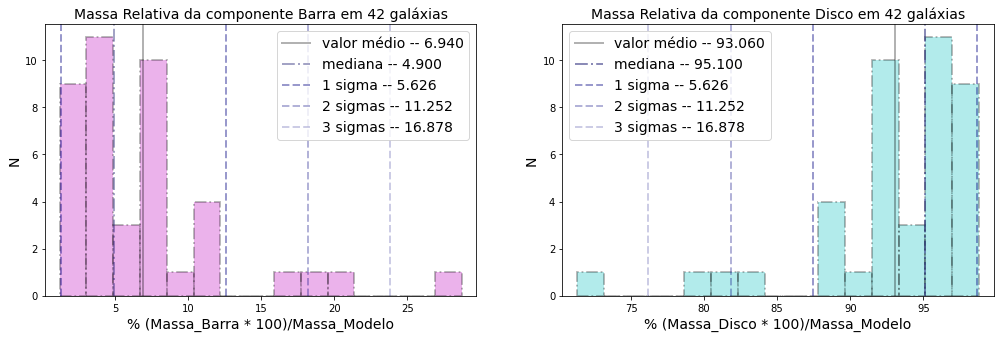

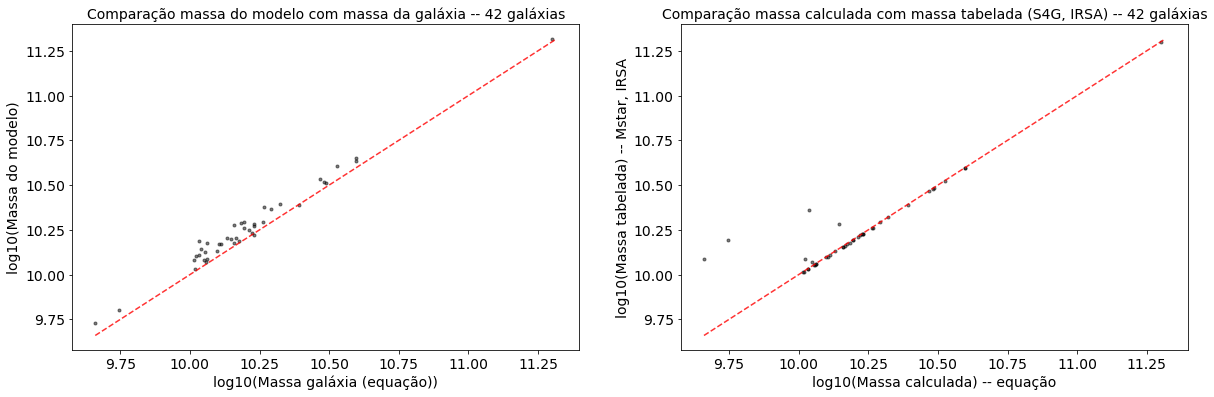

In [47]:
#muito massivas
gals_dbar(tabela=amostra_430_m10[mask].reset_index(), plot=True, saveplot=True)

/tmp/ipykernel_94180/4084178683.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gals_dbarn(tabela=amostra_430_m10[mask].reset_index(), plot=True, saveplot=True)
100%|█████████████████████████████████████████| 182/182 [00:01<00:00, 94.98it/s]


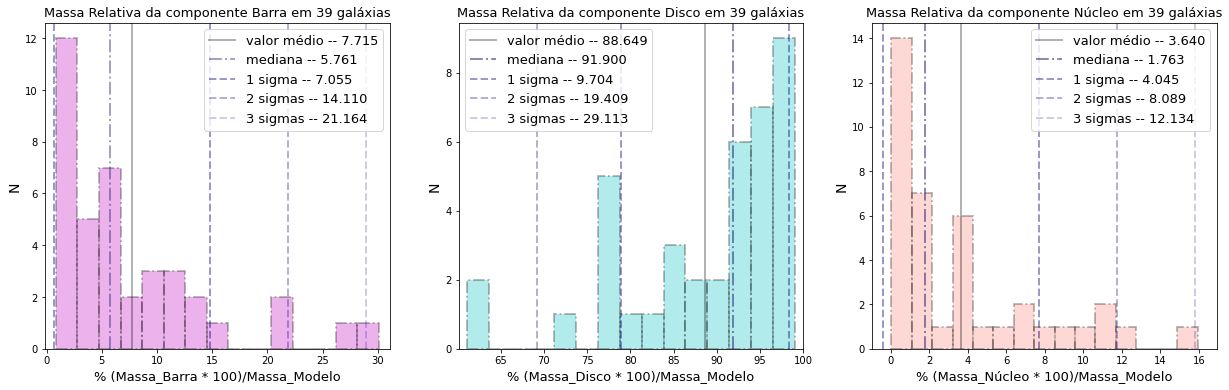

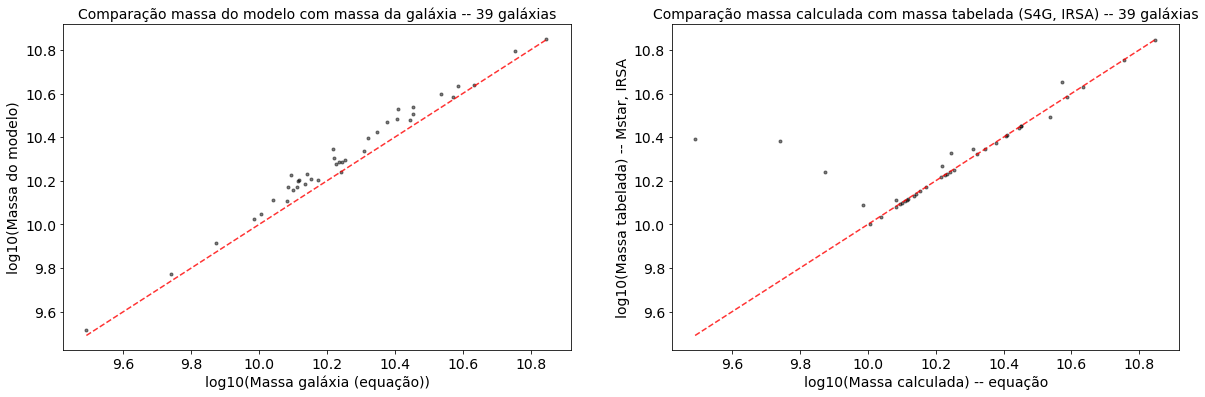

In [48]:
#muito massivas
gals_dbarn(tabela=amostra_430_m10[mask].reset_index(), plot=True, saveplot=True)

/tmp/ipykernel_94180/756014517.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gals_bdbar(tabela=amostra_430_m10[mask].reset_index(), plot=True, saveplot=True)
100%|█████████████████████████████████████████| 182/182 [00:05<00:00, 36.06it/s]


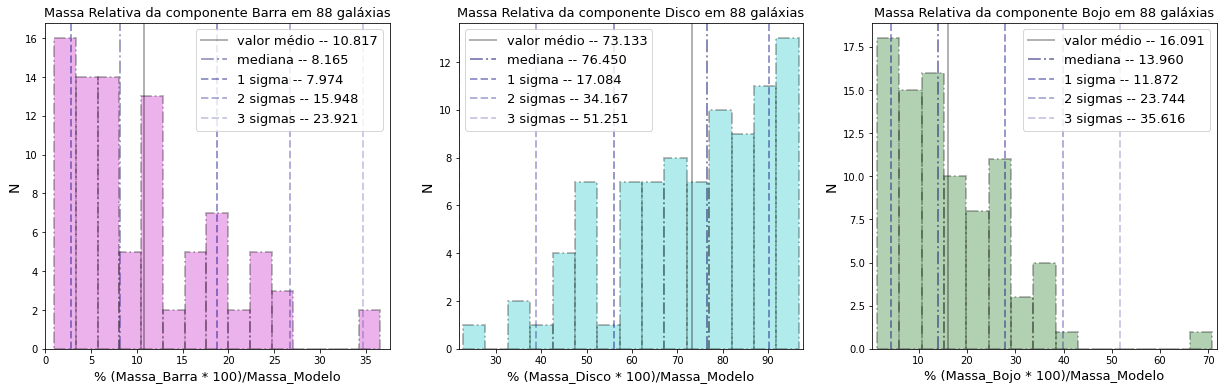

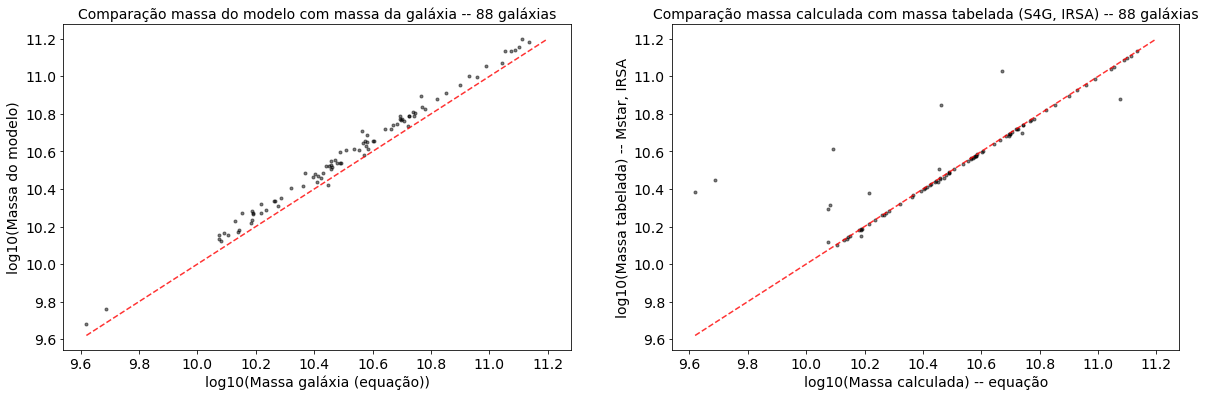

In [49]:
#muito massivas
gals_bdbar(tabela=amostra_430_m10[mask].reset_index(), plot=True, saveplot=True)

/tmp/ipykernel_94180/1519235182.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gals_bdbarn(tabela=amostra_430_m10[mask].reset_index(), plot=True, saveplot=True)
100%|████████████████████████████████████████| 182/182 [00:00<00:00, 259.44it/s]


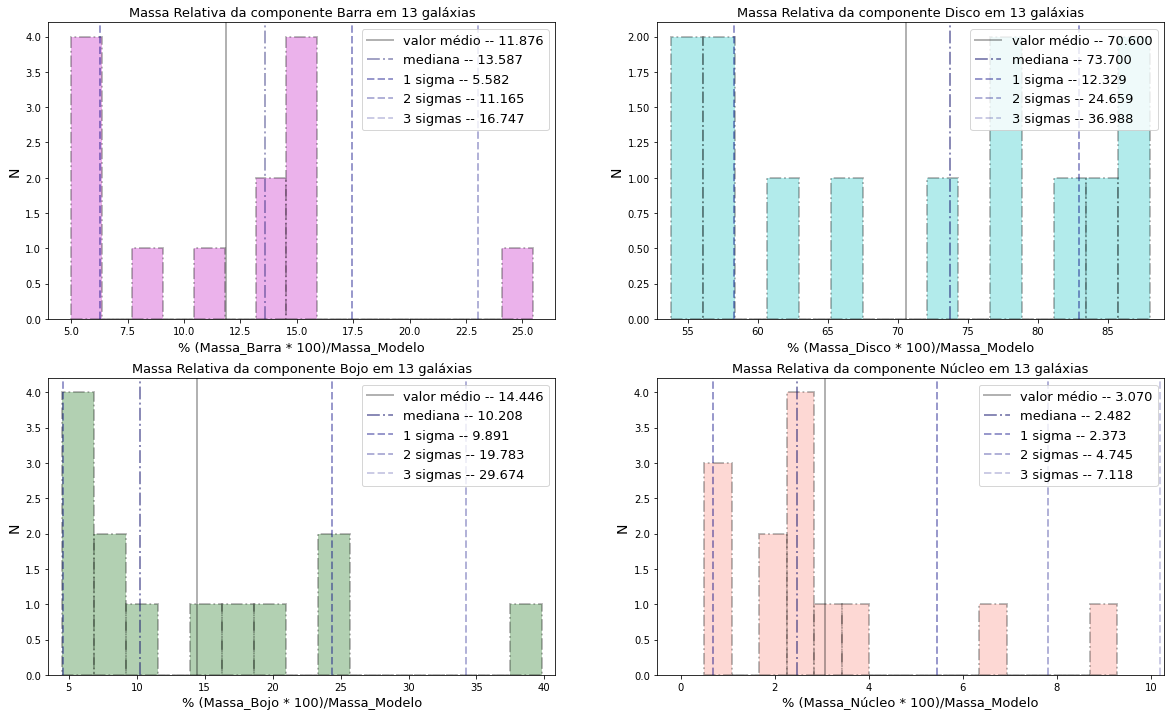

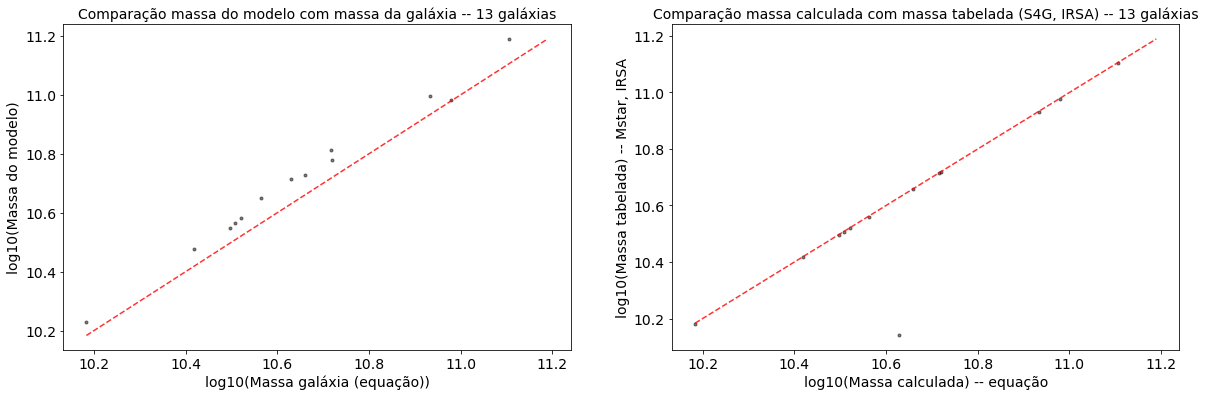

In [50]:
#muito massivas
gals_bdbarn(tabela=amostra_430_m10[mask].reset_index(), plot=True, saveplot=True)

In [51]:
#Lista com todas as massas relativas das galáxias muito massivas
MBAR_MtMass = gals_dbar(tabela=amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_dbarn(tabela
            =amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_bdbar(tabela
            =amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_bdbarn(tabela
            =amostra_430_m10[mask].reset_index(), List_MBAR=True)

print('Número de galáxias muito massivas: ', len(MBAR_MtMass))
print('Média: ',np.mean(MBAR_MtMass) )
print('Mediana: ',np.median(MBAR_MtMass))
print('Sigma: ',np.std(MBAR_MtMass))

/tmp/ipykernel_94180/3233785808.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MBAR_MtMass = gals_dbar(tabela=amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_dbarn(tabela
100%|█████████████████████████████████████████| 182/182 [00:02<00:00, 73.25it/s]
/tmp/ipykernel_94180/3233785808.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_bdbar(tabela
100%|█████████████████████████████████████████| 182/182 [00:02<00:00, 89.99it/s]
/tmp/ipykernel_94180/3233785808.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_bdbarn(tabela
100%|█████████████████████████████████████████| 182/182 [00:05<00:00, 35.51it/s]
/tmp/ipykernel_94180/3233785808.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m10[mask].reset_index(), Li

Número de galáxias muito massivas:  182
Média:  9.333231022179765
Mediana:  7.332655524683062
Sigma:  7.372039744820587


In [52]:
#Teste U de Wilcoxon-Mann-Whitney
# H0 -- os dados tem a mesma distribuição de origem 
# H1 -- A é signicativamente diferente de B

#Primeiro, junto os dados
a=MBAR_MassInt
b=MBAR_MtMass
ab = np.append(a, b)
marker = np.append(np.repeat('a',len(a)),np.repeat('b',len(b))) #quem veio de a, recebe um 'a'. 

#Calculando os ranks
N = len(ab)
rank_ab = np.zeros(N)
rank_ab[ab.argsort()] = np.arange(N, 0, -1)

Ua = np.sum(rank_ab[marker=='a'])
print('Valor de Ua -- o que vamos verificar: ',Ua)
Ub = np.sum(rank_ab[marker=='b'])
#print(Ub)

#comparar com a distribuição centrada em Ua
n = len(a)
m = len(b)

#Média de Ua
mu_a = (n*(N + 1))/2

#Sigma de Ua
sigma2_a = (m*n*(N+1))/12 #variância
sigma_a = np.sqrt(sigma2_a) #desvio padrão

#95% dos pontos de uma gaussiana se encontram entre a [média - 2*dp; média + 2*dp]
#Se queremos um grau de confiança de 5%

#O intervalo 
print('\nO intervalo: ',mu_a - 2*sigma_a, 'até', mu_a + 2*sigma_a)

if Ua > mu_a - 2*sigma_a and Ua < mu_a + 2*sigma_a:
    print('\nDentro do intervalo -- fico com H0, os dados vem de uma mesma distribuição')
else:
    print('\nFora do intervalo -- rejeito H0, os dados são significativamente diferentes')

Valor de Ua -- o que vamos verificar:  34871.0

O intervalo:  30679.030386972216 até 34660.96961302778

Fora do intervalo -- rejeito H0, os dados são significativamente diferentes


In [53]:
import scipy.stats
scipy.stats.mannwhitneyu(MBAR_MassInt,MBAR_MtMass)

print('P-value: ',scipy.stats.mannwhitneyu(MBAR_MassInt,MBAR_MtMass)[1])
print('Considerando um grau de confiança de 5%, se p-value é menor que 0.05,rejeitamos H0 (amostras com a mesma origem)')
print('Probabilidade das amostras serem significativamente diferentes: ', 
      1 -scipy.stats.mannwhitneyu(MBAR_MassInt,MBAR_MtMass)[1])

P-value:  0.027071795795811728
Considerando um grau de confiança de 5%, se p-value é menor que 0.05,rejeitamos H0 (amostras com a mesma origem)
Probabilidade das amostras serem significativamente diferentes:  0.9729282042041882


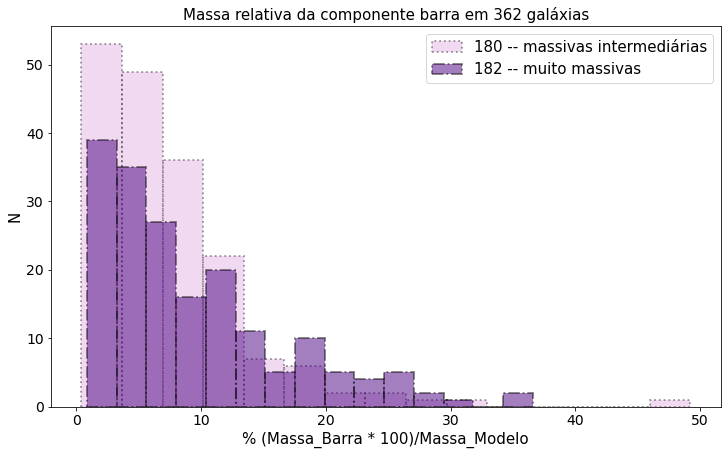

In [54]:
fig = plt.figure(figsize=(12,7))
plt.hist(MBAR_MassInt,bins=15,align='mid',color='plum',alpha = 0.4, linestyle=':',edgecolor='k', linewidth=1.8, label='180 -- massivas intermediárias')
plt.hist(MBAR_MtMass,bins=15,align='mid',color='indigo',alpha = 0.5, linestyle='-.',edgecolor='k', linewidth=1.8, label='182 -- muito massivas')
plt.legend(loc='best',fontsize=15)
plt.tick_params(labelsize=14)
plt.title('Massa relativa da componente barra em 362 galáxias',fontsize=15)
plt.ylabel('N',fontsize=15)
plt.xlabel('% (Massa_Barra * 100)/Massa_Modelo' ,fontsize=15)

image_name = 'Massa_relativa_barra_intermediarias_muimassivas.png'
plt.savefig(image_name, format='png')
plt.show()

In [55]:
#Verificando fluxo a mais na banda de 3.6
flux_mod, flux_obs = gals_dbar(tabela=amostra_430, plot=False, saveplot=False,List_flux3=True)

100%|█████████████████████████████████████████| 430/430 [00:12<00:00, 35.61it/s]


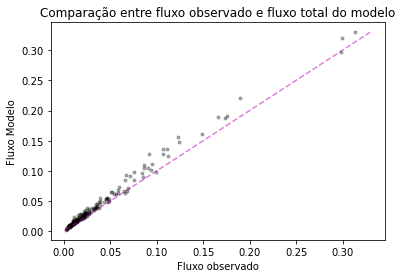

In [56]:
iden = np.linspace(np.min(flux_obs),np.max(flux_mod),num=30) # x=y
plt.plot(flux_obs,flux_mod, 'k.',alpha=0.3)
plt.title('Comparação entre fluxo observado e fluxo total do modelo')
plt.ylabel('Fluxo Modelo')
plt.xlabel('Fluxo observado')
plt.plot(iden,iden, 'm--', alpha=0.5 )
plt.show()

In [57]:
#Verificando fluxo a mais na banda de 4.5
flux_mod, flux_obs = gals_dbar(tabela=amostra_430, plot=False, saveplot=False,List_flux4=True)

100%|█████████████████████████████████████████| 430/430 [00:10<00:00, 42.36it/s]


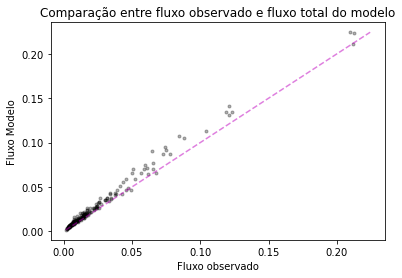

In [58]:
iden = np.linspace(np.min(flux_obs),np.max(flux_mod),num=30) # x=y
plt.plot(flux_obs,flux_mod, 'k.',alpha=0.3)
plt.title('Comparação entre fluxo observado e fluxo total do modelo')
plt.ylabel('Fluxo Modelo')
plt.xlabel('Fluxo observado')
plt.plot(iden,iden, 'm--', alpha=0.5 )
plt.show()

In [59]:
#Barras mais massivas em galáxias mais maduras? (com componente bojo)

#Lista com galáxias sem componente bojo, massivas intermediarias e muito massivas
#Modelos dbar e debarn
MBAR_NoBojo = gals_dbar(tabela=amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_dbarn(tabela
            =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_dbar(tabela
            =amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_dbarn(tabela
            =amostra_430_m10[mask].reset_index(), List_MBAR=True) 

print('Número de galáxias sem bojo em seu modelo: ', len(MBAR_NoBojo))
print('Média: ',np.mean(MBAR_NoBojo) )
print('Mediana: ',np.median(MBAR_NoBojo))
print('Sigma: ',np.std(MBAR_NoBojo))

#Lista com todas as massas relativas das galáxias muito massivas
MBAR_Bojo =  gals_bdbar(tabela
            =amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_bdbarn(tabela
            =amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_bdbar(tabela
            =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_bdbarn(tabela
            =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True)

print('\n\nNúmero de galáxias com bojo em seu modelo: ', len(MBAR_Bojo))
print('Média: ',np.mean(MBAR_Bojo) )
print('Mediana: ',np.median(MBAR_Bojo))
print('Sigma: ',np.std(MBAR_Bojo))

/tmp/ipykernel_94180/3909786431.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MBAR_NoBojo = gals_dbar(tabela=amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_dbarn(tabela
100%|█████████████████████████████████████████| 180/180 [00:06<00:00, 26.47it/s]
/tmp/ipykernel_94180/3909786431.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_dbar(tabela
100%|█████████████████████████████████████████| 180/180 [00:02<00:00, 76.91it/s]
/tmp/ipykernel_94180/3909786431.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_dbarn(tabela
100%|█████████████████████████████████████████| 182/182 [00:02<00:00, 75.05it/s]
/tmp/ipykernel_94180/3909786431.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m10[mask].reset_index()

Número de galáxias sem bojo em seu modelo:  248
Média:  7.249002715173118
Mediana:  5.9000219004195555
Sigma:  6.053619606717672


100%|█████████████████████████████████████████| 182/182 [00:05<00:00, 35.81it/s]
/tmp/ipykernel_94180/3909786431.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m10[mask].reset_index(), List_MBAR=True) + gals_bdbar(tabela
100%|████████████████████████████████████████| 182/182 [00:00<00:00, 245.41it/s]
/tmp/ipykernel_94180/3909786431.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True) + gals_bdbarn(tabela
100%|████████████████████████████████████████| 180/180 [00:00<00:00, 367.56it/s]
/tmp/ipykernel_94180/3909786431.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  =amostra_430_m9_m10[mask].reset_index(), List_MBAR=True)
100%|███████████████████████████████████████| 180/180 [00:00<00:00, 1193.18it/s]



Número de galáxias com bojo em seu modelo:  114
Média:  10.853764326348237
Mediana:  8.558410189562302
Sigma:  7.775736900834301


In [60]:
#Teste U de Wilcoxon-Mann-Whitney
# H0 -- os dados tem a mesma distribuição de origem 
# H1 -- A é signicativamente diferente de B

#Primeiro, junto os dados
a=MBAR_NoBojo
b=MBAR_Bojo
ab = np.append(a, b)
marker = np.append(np.repeat('a',len(a)),np.repeat('b',len(b))) #quem veio de a, recebe um 'a'. 

#Calculando os ranks
N = len(ab)
rank_ab = np.zeros(N)
rank_ab[ab.argsort()] = np.arange(N, 0, -1)

Ua = np.sum(rank_ab[marker=='a'])
print('Valor de Ua -- o que vamos verificar: ',Ua)
Ub = np.sum(rank_ab[marker=='b'])
#print(Ub)

#comparar com a distribuição centrada em Ua
n = len(a)
m = len(b)

#Média de Ua
mu_a = (n*(N + 1))/2

#Sigma de Ua
sigma2_a = (m*n*(N+1))/12 #variância
sigma_a = np.sqrt(sigma2_a) #desvio padrão

#95% dos pontos de uma gaussiana se encontram entre a [média - 2*dp; média + 2*dp]
#Se queremos um grau de confiança de 5%

#O intervalo 
print('\nO intervalo: ',mu_a - 2*sigma_a, 'até', mu_a + 2*sigma_a)

if Ua > mu_a - 2*sigma_a and Ua < mu_a + 2*sigma_a:
    print('\nDentro do intervalo -- fico com H0, os dados vem de uma mesma distribuição')
else:
    print('\nFora do intervalo -- rejeito H0, os dados são significativamente diferentes')

Valor de Ua -- o que vamos verificar:  49053.0

O intervalo:  43162.42923898543 até 46861.57076101457

Fora do intervalo -- rejeito H0, os dados são significativamente diferentes


In [61]:
#Test U
scipy.stats.mannwhitneyu(MBAR_NoBojo,MBAR_Bojo)

print('P-value: ',scipy.stats.mannwhitneyu(MBAR_NoBojo,MBAR_Bojo)[1])
print('Considerando um grau de confiança de 5%, se p-value é menor que 0.05,rejeitamos H0 (amostras com a mesma origem)')
print('Probabilidade das amostras serem significativamente diferentes: ', 
      1 -scipy.stats.mannwhitneyu(MBAR_NoBojo,MBAR_Bojo)[1])

P-value:  1.2474684281109736e-05
Considerando um grau de confiança de 5%, se p-value é menor que 0.05,rejeitamos H0 (amostras com a mesma origem)
Probabilidade das amostras serem significativamente diferentes:  0.9999875253157189


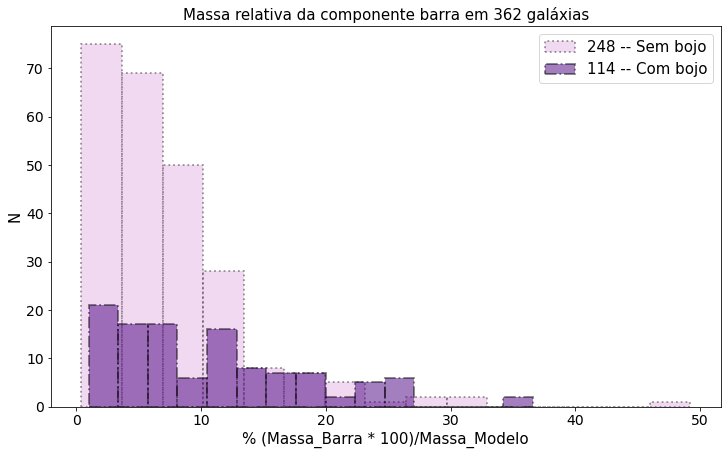

In [62]:
fig = plt.figure(figsize=(12,7))
plt.hist(MBAR_NoBojo,bins=15,align='mid',color='plum',alpha = 0.4, linestyle=':',edgecolor='k', linewidth=1.8, label='248 -- Sem bojo')
plt.hist(MBAR_Bojo,bins=15,align='mid',color='indigo',alpha = 0.5, linestyle='-.',edgecolor='k', linewidth=1.8, label='114 -- Com bojo')
plt.legend(loc='best',fontsize=15)
plt.tick_params(labelsize=14)
plt.title('Massa relativa da componente barra em 362 galáxias',fontsize=15)
plt.ylabel('N',fontsize=15)
plt.xlabel('% (Massa_Barra * 100)/Massa_Modelo' ,fontsize=15)

image_name = 'Massa_relativa_barra_bojo_e_sembojo.png'
plt.savefig(image_name, format='png')
plt.show()



100%|█████████████████████████████████████████| 194/194 [00:06<00:00, 27.79it/s]


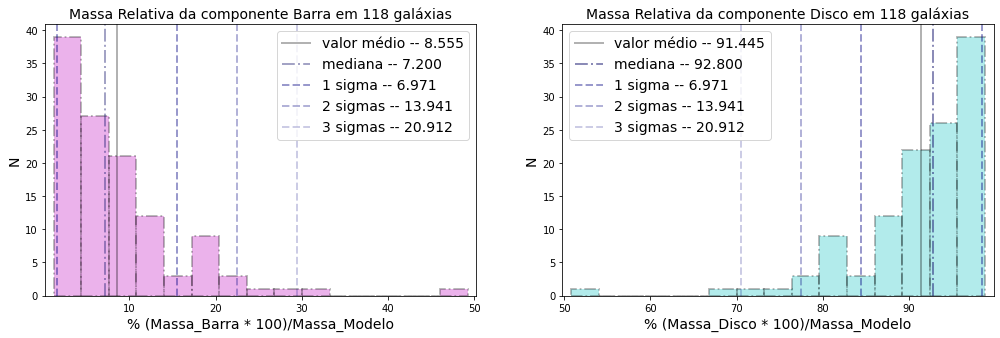

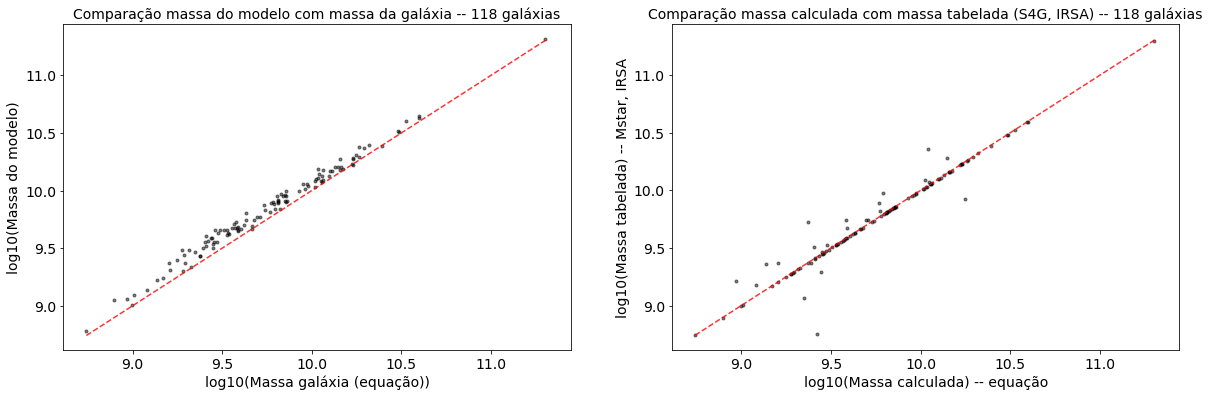

In [63]:
#Olhando só para as barras fortes 
mask1 = amostra_430['__F_'] == 1.0 #mascara para olhar as barras

#Modelo Disco+Barra
gals_dbar(tabela=amostra_430[mask1].reset_index(), plot=True, saveplot=True)

100%|█████████████████████████████████████████| 194/194 [00:02<00:00, 94.09it/s]


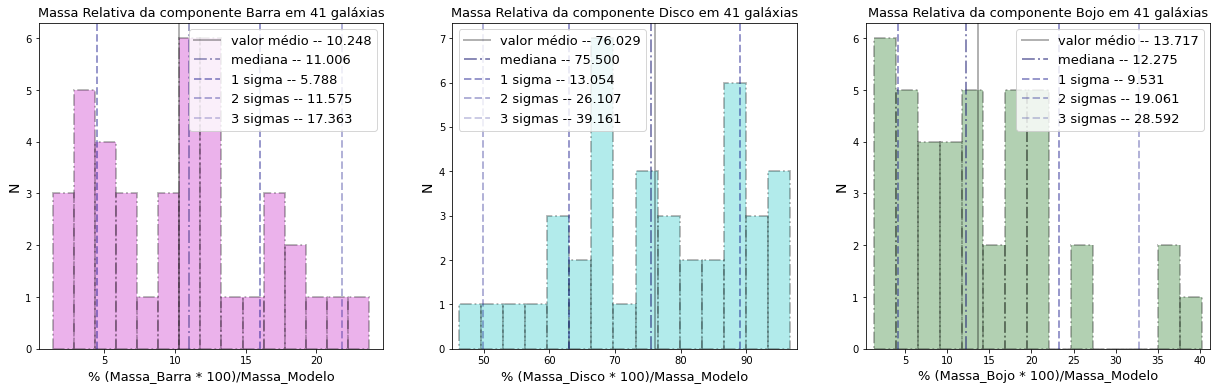

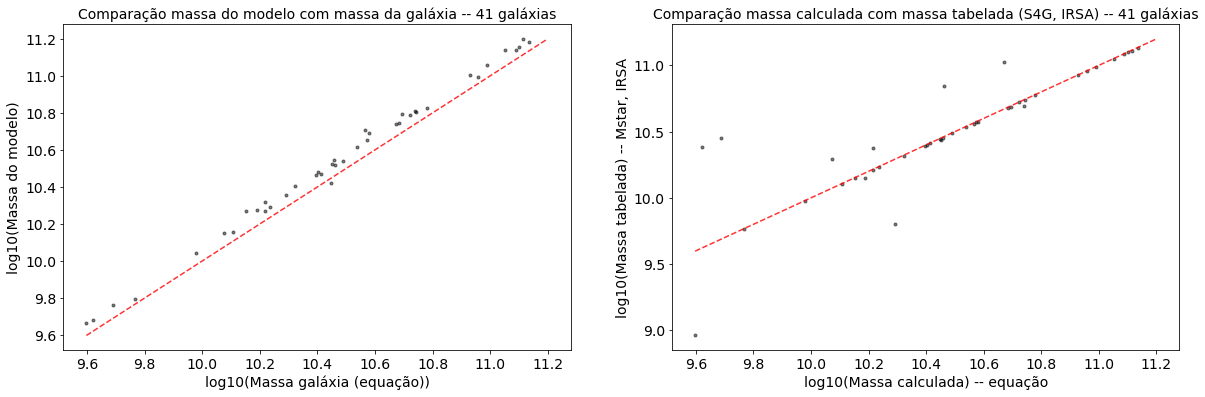

In [64]:
#Modelo Disco+Barra+bojo
gals_bdbar(tabela=amostra_430[mask1].reset_index(), plot=True, saveplot=True)

100%|████████████████████████████████████████| 194/194 [00:01<00:00, 109.39it/s]


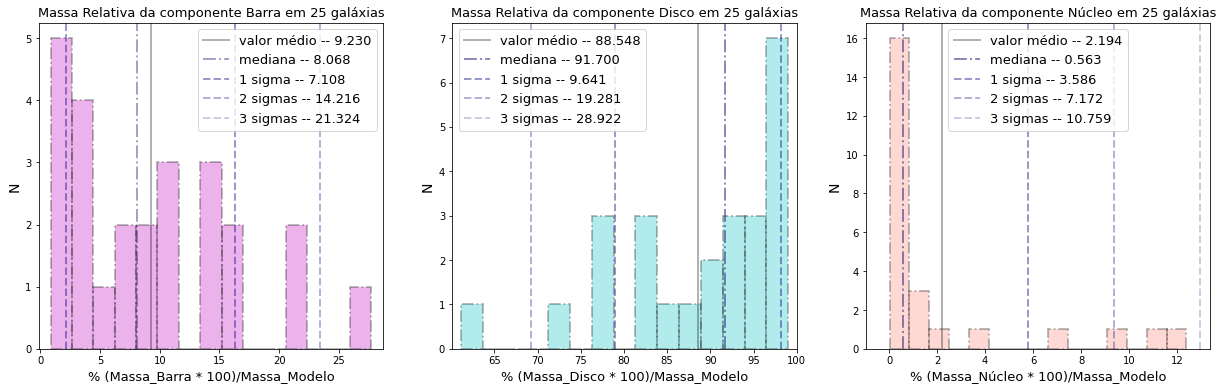

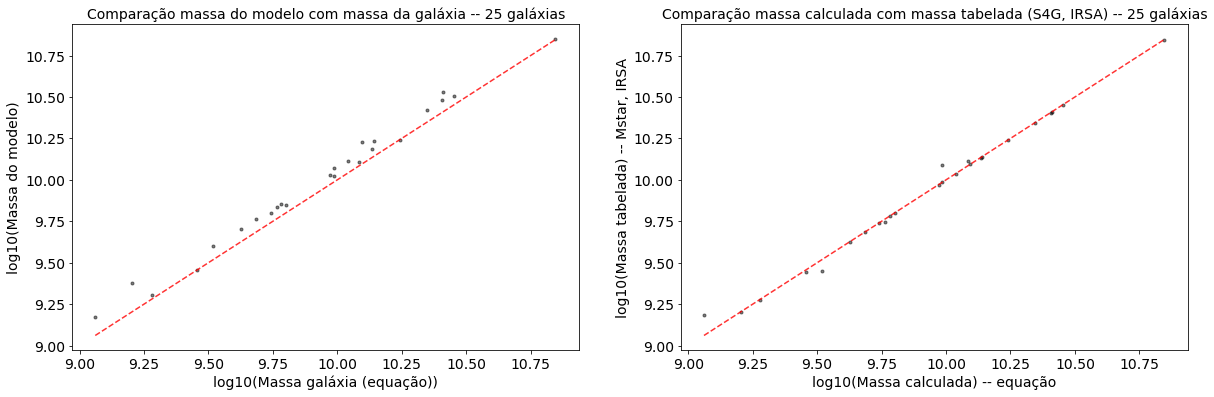

In [65]:
#Modelo Disco+Barra+nucleo
gals_dbarn(tabela=amostra_430[mask1].reset_index(), plot=True, saveplot=True)

100%|████████████████████████████████████████| 194/194 [00:00<00:00, 338.63it/s]


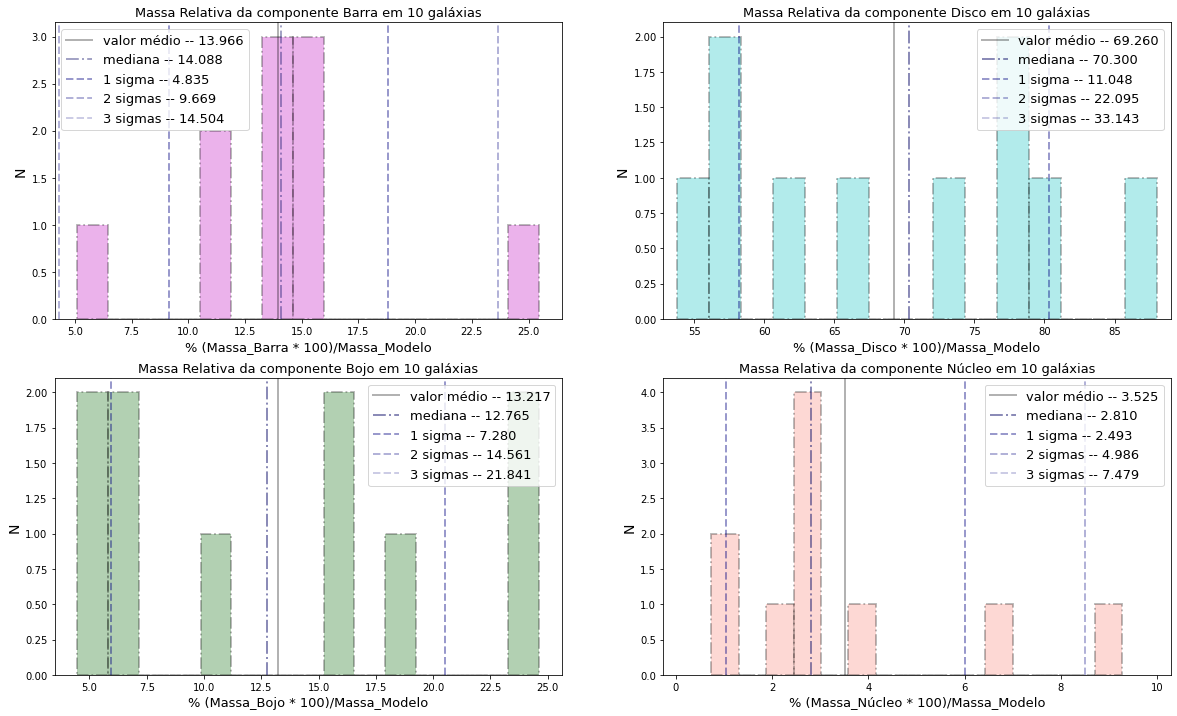

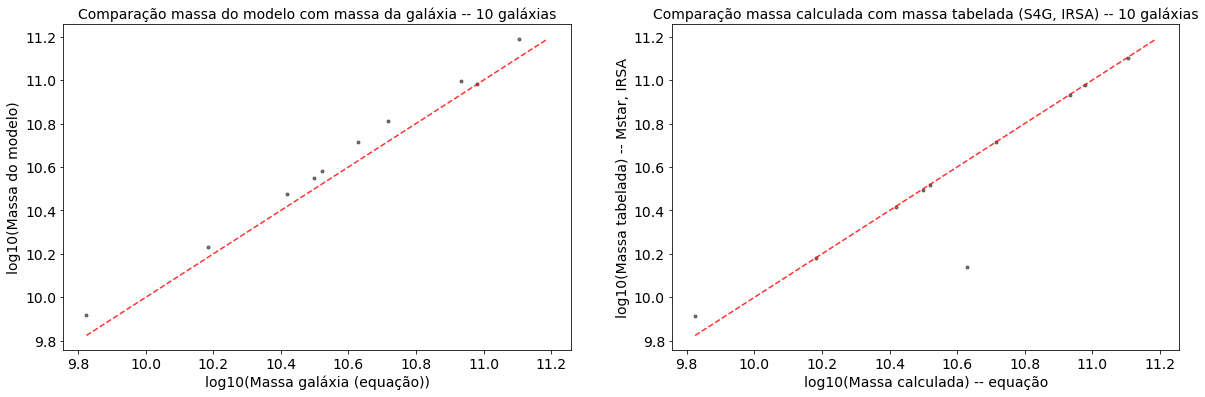

In [66]:
#Modelo Disco+Barra+bojo+nucleo
gals_bdbarn(tabela=amostra_430[mask1].reset_index(), plot=True, saveplot=True)

In [67]:
amostra_430[mask1]

Name_1     Mod  Nc  Q    C       Fn  f1  mag1_1  f2  mu02  ...  \
1    ESO013-016  _dbarf   2  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   
4    ESO048-017  _ndbar   3  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   
5    ESO079-007   _dbar   2  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   
9    ESO340-017   _dbar   2  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   
19   ESO440-011  _dbarf   2  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   
..          ...     ...  .. ..  ...      ...  ..     ...  ..   ...  ...   
417    UGC09569   _dbar   2  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   
419    UGC09661   _dbar   2  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   
420    UGC09730   _dbar   2  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   
424    UGC11782  _dbarf   2  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   
425    UGC12151   _dbar   2  5  BAR  ferrer2 NaN     NaN NaN   NaN  ...   

     mag1_2    mag2   mstar   dmean  type  t_1   incl  Dist  __T_  __F_  
1    13.127  13.506   9.564  23.017   SBd  7.5  56.71  23.0   6.0   1.0  
4    14.726  15.188   9.202  29.520  SBcd  6.9  62.52  29.5   9.0   1.0  
5    13.570  13.956   9.471  25.220  SBbc  4.0  39.25  25.2   8.0   1.0  
9    13.626  14.074   9.782     NaN   SBd  8.0  64.13  35.0   7.0   1.0  
19   12.430  12.850  10.031  27.600   Scd  6.9  52.89  27.6   6.0   1.0  
..      ...     ...     ...     ...   ...  ...    ...   ...   ...   ...  
417  14.346  14.736   9.512     NaN  SBcd  6.6  34.95  33.2   5.0   1.0  
419  13.775  14.232   9.180     NaN   SBd  8.0  28.46  16.6   8.0   1.0  
420  14.570  14.998   9.366     NaN   Scd  6.6  43.83  28.4   5.0   1.0  
424  14.236  14.816   9.005  17.000   SBm  8.8  61.48  17.0   9.5   1.0  
425  14.122  14.662   9.314  23.800    IB  9.7  51.43  23.8   7.0   1.0  

[194 rows x 26 columns]